In [4]:
import numpy as np
import matplotlib.pyplot as plt
# import skfuzzy as fuzz
from sklearn.cluster import KMeans
from L63_noisy import intL63_noisy, intL63_noisy_fix
from mpl_toolkits.mplot3d import Axes3D
from statsmodels.tsa import stattools 
from scipy.stats import gaussian_kde

# from sklearn.metrics import silhouette_score


# fix the random seed
np.random.seed(2022)

# set experiment parameters
dt = 0.005  # model integration time step, dtda should be divisible to dt
N = 20000  # integration time steps

# set L63 model parameters
par = (10, 28, 8 / 3)  # sigma, rho, beta
sigma = (5, 5, 5)

# create the nature run
# # X0 = np.random.normal(0, 1, (3, 1))
# # truth = intL63_noisy(X0, par[0], par[1], par[2], sigma[0], sigma[1], sigma[2], dt, N, 1)
truth = np.load('../../data/nature_run1.npy')
y0 = np.random.normal(0,1,(3,1))


# 1. Classification

## 1.1 autocorrelation

x Decorrelation Time: 0.21 time units
y Decorrelation Time: 0.16 time units
z Decorrelation Time: 0.12 time units


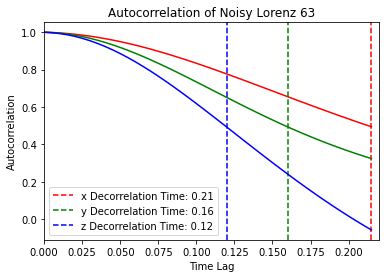

In [53]:
# autocorrelation
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa import stattools 


autocorr_x = stattools.acf(truth[0,0,:])  # Autocorrelation of x component
autocorr_y = stattools.acf(truth[1,0,:])  # Autocorrelation of y component
autocorr_z = stattools.acf(truth[2,0,:])  # Autocorrelation of z component

# Find decorrelation time (time lag at which autocorrelation drops to a certain threshold)
threshold = 0.5
decorrelation_time_index = np.argmax(autocorr_x < threshold)
decorrelation_time_x = decorrelation_time_index * dt
decorrelation_time_index = np.argmax(autocorr_y < threshold)
decorrelation_time_y = decorrelation_time_index * dt
decorrelation_time_index = np.argmax(autocorr_z < threshold)
decorrelation_time_z = decorrelation_time_index * dt

tmax = dt*autocorr_x.shape[0]
t = np.arange(0.0, tmax, dt)
# Plot autocorrelation function and decorrelation time
plt.plot(t, autocorr_x, color='r')
plt.axvline(x=decorrelation_time_x, color='r', linestyle='--', label=f'x Decorrelation Time: {decorrelation_time_x:.2f}')
plt.plot(t, autocorr_y, color='g')
plt.axvline(x=decorrelation_time_y, color='g', linestyle='--', label=f'y Decorrelation Time: {decorrelation_time_y:.2f}')
plt.plot(t, autocorr_z, color='b')
plt.axvline(x=decorrelation_time_z, color='b', linestyle='--', label=f'z Decorrelation Time: {decorrelation_time_z:.2f}')
plt.xlabel('Time Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation of Noisy Lorenz 63')
plt.legend()
plt.xlim(0, tmax)
# plt.show()
plt.savefig('../../fig/autocorr_L63.png', dpi=150)

print(f"x Decorrelation Time: {decorrelation_time_x:.2f} time units")
print(f"y Decorrelation Time: {decorrelation_time_y:.2f} time units")
print(f"z Decorrelation Time: {decorrelation_time_z:.2f} time units")



## 1.2 Clustering

### 1.2.1 K-means

Cluster 1 Center: [-5.80787356e+00 -7.02166380e+00  2.41455552e+01 -7.13288492e-02
 -1.26644365e-02 -1.14036344e-02 -6.26100482e+00 -6.97125805e+00
  2.40604228e+01 -4.55200323e-02  1.70477786e-02 -1.03681002e-02
 -6.51104847e+00 -6.77154976e+00  2.39842571e+01 -2.11769236e-02
  2.82199077e-02 -8.23186913e-03 -6.58945387e+00 -6.52487656e+00
  2.39243331e+01 -3.04127982e-03  3.13535069e-02 -7.14601570e-03
 -6.55724514e+00 -6.26268096e+00  2.38674208e+01  8.18039983e-03
  3.31562066e-02 -6.15658211e-03]
Cluster 2 Center: [ 6.03639447e+00  7.54729466e+00  2.43586134e+01  8.37125843e-02
  1.37713341e-02  1.59156225e-02  6.56470788e+00  7.47524990e+00
  2.44804631e+01  5.27601770e-02 -2.19639358e-02  1.52178769e-02
  6.85004909e+00  7.22229582e+00  2.45963086e+01  2.36181304e-02
 -3.55966709e-02  1.31065092e-02  6.93000746e+00  6.91234116e+00
  2.46945998e+01  1.88360606e-03 -3.93681323e-02  1.19305704e-02
  6.87898755e+00  6.58498071e+00  2.47884004e+01 -1.15700520e-02
 -4.15276547e-02  1.

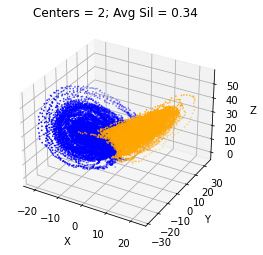

In [16]:
# Kmeans
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from FKNN import FuzzyKNN, calculate_distances
import joblib
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score


# Define a custom function to evaluate the predictions with multiple metrics
def evaluate_predictions(truth_label, predicted_label):
    accuracy = accuracy_score(truth_label, predicted_label)
    precision = precision_score(truth_label, predicted_label, average='macro')
    recall = recall_score(truth_label, predicted_label, average='macro')
    return accuracy, precision, recall,

np.random.seed(2022)

# Load L63 time series data X
# load labeled time series data
sol = np.squeeze(np.load('nature_run1.npy'))
der = np.squeeze(np.load('derivative.npy'))
X = np.concatenate([sol, der], axis=0).T   # X should be a 2D array with shape (n_samples, n_features)

lagtime = 32
laginter = 8
sequence_length = int(lagtime/laginter)+1  # length of time sequences
# create sequence data
X_new = np.zeros((X.shape[0]-lagtime, sequence_length,X.shape[1],))
for i in range(X.shape[0]-lagtime):
    X_new[i,:,:] = X[i:i+lagtime+1:laginter,:]
X_new = X_new.reshape(X.shape[0]-lagtime, -1)
X_new.shape

# -------------------------------------------------
# K-means clustering
# Create feature matrix (x, y, z) for clustering
data_matrix = np.squeeze(truth).T
x_data = data_matrix[lagtime:, 0]
y_data = data_matrix[lagtime:, 1]
z_data = data_matrix[lagtime:, 2]
data_matrix = X_new
colors = ['b', 'orange', 'g', 'r']

# Set up the loop and plot
fig =  plt.figure()
ax = fig.add_subplot(111, projection='3d')
ncenters = 2
kmeans = KMeans(n_clusters=ncenters)
kmeans.fit(data_matrix)
labels = kmeans.labels_
# np.save('Kmeans_label_{0:d}center.npy'.format(ncenters), labels)

# Save the model
joblib.dump(kmeans, "kmeans_model.joblib")

# Print the cluster centers
cluster_centers = kmeans.cluster_centers_
for i, center in enumerate(cluster_centers):
    print(f"Cluster {i + 1} Center: {center}")

# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed
# clusters
sil_avg = silhouette_score(data_matrix, labels)

# Plot assigned clusters, for each data point in training set
for j in range(ncenters):
    ax.scatter(x_data[labels == j], y_data[labels == j], z_data[labels == j],
               label=f'Regime {j+1}', s=.5, color=colors[j])
    # ax.scatter(cluster_centers[j, 0], cluster_centers[j, 1], cluster_centers[j, 2], marker='*', s=200, color='black',zorder=1)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

ax.set_title('Centers = {0}; Avg Sil = {1:.2f}'.format(ncenters, sil_avg))
# plt.savefig('../../fig/SequenceKmeans.png')
# plt.subplots_adjust(wspace=0.25)  # Increased the width of intervals among subplots
plt.show()


In [139]:
# save labeled data
np.save('SeqKmeans_label_{0:d}center_naturerun.npy'.format(ncenters), labels)


Cluster 1 Center: [-5.80950294e+00 -7.02237741e+00  2.41441637e+01 -7.12817284e-02
 -1.26115234e-02 -1.13409405e-02 -6.26225893e+00 -6.97149205e+00
  2.40594180e+01 -4.54459205e-02  1.71340280e-02 -1.02392355e-02
 -6.51197350e+00 -6.77184718e+00  2.39836861e+01 -2.11363397e-02
  2.81761828e-02 -8.13939005e-03 -6.59010232e+00 -6.52499888e+00
  2.39240100e+01 -3.01000050e-03  3.13946018e-02 -7.11682142e-03
 -6.55769440e+00 -6.26267959e+00  2.38673496e+01  8.19100230e-03
  3.31941283e-02 -6.15097487e-03]
Cluster 2 Center: [ 6.03703205e+00  7.54654612e+00  2.43602427e+01  8.36396353e-02
  1.37055950e-02  1.58381703e-02  6.56479224e+00  7.47394515e+00
  2.44816105e+01  5.26613901e-02 -2.20620973e-02  1.50620259e-02
  6.84968397e+00  7.22111598e+00  2.45969197e+01  2.35650228e-02
 -3.55377491e-02  1.29943374e-02  6.92929650e+00  6.91101435e+00
  2.46948991e+01  1.84591719e-03 -3.94091915e-02  1.18938075e-02
  6.87804913e+00  6.58357158e+00  2.47883841e+01 -1.15804805e-02
 -4.15645111e-02  1.

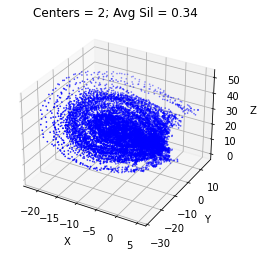

In [185]:
# Set up the loop and plot
fig =  plt.figure()
ax = fig.add_subplot(111, projection='3d')
ncenters = 2
kmeans = KMeans(n_clusters=ncenters)
kmeans.fit(data_matrix)
labels = kmeans.labels_
# np.save('Kmeans_label_{0:d}center.npy'.format(ncenters), labels)

# Print the cluster centers
cluster_centers = kmeans.cluster_centers_
for i, center in enumerate(cluster_centers):
    print(f"Cluster {i + 1} Center: {center}")

# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed
# clusters
sil_avg = silhouette_score(data_matrix, labels)

# Plot assigned clusters, for each data point in training set
j=0
ax.scatter(x_data[labels == j], y_data[labels == j], z_data[labels == j],
           label=f'Regime {j+1}', s=.5, color=colors[j])
# ax.scatter(cluster_centers[j, 0], cluster_centers[j, 1], cluster_centers[j, 2], marker='*', s=200, color='black',zorder=1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.set_title('Centers = {0}; Avg Sil = {1:.2f}'.format(ncenters, sil_avg))
plt.savefig('../../fig/SequenceKmeans_half.png')
# plt.subplots_adjust(wspace=0.25)  # Increased the width of intervals among subplots
plt.show()

Cluster 1 Center: [-5.80787356e+00 -7.02166380e+00  2.41455552e+01 -7.13288492e-02
 -1.26644365e-02 -1.14036344e-02 -6.26100482e+00 -6.97125805e+00
  2.40604228e+01 -4.55200323e-02  1.70477786e-02 -1.03681002e-02
 -6.51104847e+00 -6.77154976e+00  2.39842571e+01 -2.11769236e-02
  2.82199077e-02 -8.23186913e-03 -6.58945387e+00 -6.52487656e+00
  2.39243331e+01 -3.04127982e-03  3.13535069e-02 -7.14601570e-03
 -6.55724514e+00 -6.26268096e+00  2.38674208e+01  8.18039983e-03
  3.31562066e-02 -6.15658211e-03]
Cluster 2 Center: [ 6.03639447e+00  7.54729466e+00  2.43586134e+01  8.37125843e-02
  1.37713341e-02  1.59156225e-02  6.56470788e+00  7.47524990e+00
  2.44804631e+01  5.27601770e-02 -2.19639358e-02  1.52178769e-02
  6.85004909e+00  7.22229582e+00  2.45963086e+01  2.36181304e-02
 -3.55966709e-02  1.31065092e-02  6.93000746e+00  6.91234116e+00
  2.46945998e+01  1.88360606e-03 -3.93681323e-02  1.19305704e-02
  6.87898755e+00  6.58498071e+00  2.47884004e+01 -1.15700520e-02
 -4.15276547e-02  1.

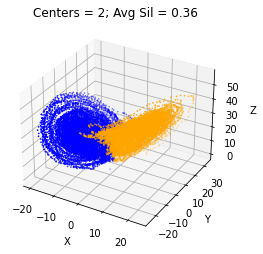

In [295]:
# label test data
# Load L63 time series data X
# load labeled time series data
sol = np.squeeze(np.load('sol_test.npy'))
der = np.squeeze(np.load('der_test.npy'))
X = np.concatenate([sol, der], axis=0).T   # X should be a 2D array with shape (n_samples, n_features)

lagtime = 32
laginter = 8
sequence_length = int(lagtime/laginter)+1  # length of time sequences
# create sequence data
X_new = np.zeros((X.shape[0]-lagtime, sequence_length,X.shape[1],))
for i in range(X.shape[0]-lagtime):
    X_new[i,:,:] = X[i:i+lagtime+1:laginter,:]
X_new = X_new.reshape(X.shape[0]-lagtime, -1)
X_new.shape

data_matrix = X_new
colors = ['b', 'orange', 'g', 'r']

# Set up the loop and plot
fig =  plt.figure()
ax = fig.add_subplot(111, projection='3d')
ncenters = 2
kmeans_load = joblib.load('kmeans_model.joblib')
labels = kmeans.predict(data_matrix)

np.save('SeqKmeans_label_2center_test.npy', labels)


# Print the cluster centers
cluster_centers = kmeans_load.cluster_centers_
for i, center in enumerate(cluster_centers):
    print(f"Cluster {i + 1} Center: {center}")

# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed
# clusters
sil_avg = silhouette_score(data_matrix, labels)

# Plot assigned clusters, for each data point in training set
data_matrix = np.squeeze(sol).T
x_data = data_matrix[lagtime:, 0]
y_data = data_matrix[lagtime:, 1]
z_data = data_matrix[lagtime:, 2]
for j in range(ncenters):
    ax.scatter(x_data[labels == j], y_data[labels == j], z_data[labels == j],
               label=f'Regime {j+1}', s=.5, color=colors[j])
    # ax.scatter(cluster_centers[j, 0], cluster_centers[j, 1], cluster_centers[j, 2], marker='*', s=200, color='black',zorder=1)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

ax.set_title('Centers = {0}; Avg Sil = {1:.2f}'.format(ncenters, sil_avg))
plt.savefig('../../fig/SequenceKmeans_test.png')
# plt.subplots_adjust(wspace=0.25)  # Increased the width of intervals among subplots
plt.show()

### 1.2.2 Fuzzy C-Means

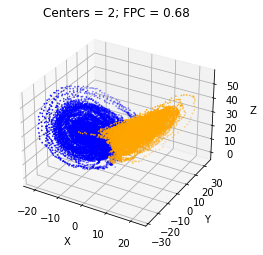

In [109]:
# Fuzzy C-Means
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from FKNN import FuzzyKNN, calculate_distances
import joblib
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score
import skfuzzy as fuzz
from sklearn.cluster import KMeans



# Define a custom function to evaluate the predictions with multiple metrics
def evaluate_predictions(truth_label, predicted_label):
    accuracy = accuracy_score(truth_label, predicted_label)
    precision = precision_score(truth_label, predicted_label, average='macro')
    recall = recall_score(truth_label, predicted_label, average='macro')
    return accuracy, precision, recall,

np.random.seed(2022)

# Load L63 time series data X
# load labeled time series data
sol = np.squeeze(np.load('nature_run1.npy'))
der = np.squeeze(np.load('derivative.npy'))
X = np.concatenate([sol, der], axis=0).T   # X should be a 2D array with shape (n_samples, n_features)

lagtime = 32
laginter = 8
sequence_length = int(lagtime/laginter)+1  # length of time sequences
# create sequence data
X_new = np.zeros((X.shape[0]-lagtime, sequence_length,X.shape[1],))
for i in range(X.shape[0]-lagtime):
    X_new[i,:,:] = X[i:i+lagtime+1:laginter,:]
X_new = X_new.reshape(X.shape[0]-lagtime, -1)
X_new.shape

# -------------------------------------------------
# Fuzzy C-Means
# Create feature matrix (x, y, z) for clustering
data_matrix = np.squeeze(truth).T
x_data = data_matrix[lagtime:, 0]
y_data = data_matrix[lagtime:, 1]
z_data = data_matrix[lagtime:, 2]
data_matrix = X_new
colors = ['b', 'orange', 'g', 'r']

# Set up the loop and plot
fig =  plt.figure()
ax = fig.add_subplot(111, projection='3d')
ncenters = 2

# # Perform Fuzzy C-means clustering
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    data_matrix.T, ncenters, 2, error=.005, maxiter=1000, init=None)

# Plot assigned clusters, for each data point in training set
cluster_membership = np.argmax(u, axis=0)
np.save('FuzKmeansTCons_label_{0:d}center.npy'.format(ncenters), cluster_membership)

for j in range(ncenters):
    ax.scatter(x_data[cluster_membership == j], y_data[cluster_membership == j], z_data[cluster_membership == j],
               label=f'Regime {j+1}', s=.5, color=colors[j])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

# Mark the center of each fuzzy cluster
for pt in cntr:
    ax.scatter(pt[0], pt[1], pt[2], marker='s', s=100, color='red')

ax.set_title('Centers = {0}; FPC = {1:.2f}'.format(ncenters, fpc))
plt.savefig('../../fig/SequenceFCmeans.png')
plt.show()


# # save labeled data
# np.save('SeqFCmeans_label_{0:d}center_naturerun.npy'.format(ncenters), labels)


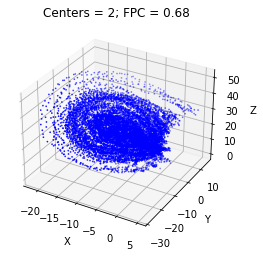

In [107]:
# Plot assigned clusters, for each data point in training set
# Set up the loop and plot
fig =  plt.figure()
ax = fig.add_subplot(111, projection='3d')

j=0
ax.scatter(x_data[cluster_membership == j], y_data[cluster_membership == j], z_data[cluster_membership == j],
           label=f'Regime {j+1}', s=.5, color=colors[j])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.set_title('Centers = {0}; FPC = {1:.2f}'.format(ncenters, fpc))
plt.savefig('../../fig/SequenceFCmeans_half.png')
plt.show()

In [108]:
cntr

array([[-5.43746221e+00, -6.64498560e+00,  2.43020791e+01,
        -6.94065772e-02, -3.46352455e-02,  1.84152954e-03,
        -5.92410296e+00, -6.82400999e+00,  2.43675403e+01,
        -5.43613010e-02, -1.40914317e-02,  1.28166569e-02,
        -6.28143050e+00, -6.85263676e+00,  2.45052259e+01,
        -3.77383389e-02,  3.50007795e-03,  2.01329510e-02,
        -6.50404784e+00, -6.75047072e+00,  2.46819728e+01,
        -2.08911733e-02,  1.91249565e-02,  2.32252297e-02,
        -6.59182328e+00, -6.52750266e+00,  2.48646524e+01,
        -4.26451551e-03,  3.36963893e-02,  2.26295613e-02],
       [ 4.93343435e+00,  6.32117253e+00,  2.41416035e+01,
         7.50510093e-02,  3.62937697e-02, -3.06633772e-03,
         5.45654225e+00,  6.50290077e+00,  2.41672298e+01,
         5.81668463e-02,  1.35399613e-02,  7.68358118e-03,
         5.83602518e+00,  6.52058221e+00,  2.42677971e+01,
         3.98121452e-02, -5.31331773e-03,  1.58468427e-02,
         6.06838834e+00,  6.40031188e+00,  2.44183155e+

## 1.3 Classification

In [3]:
# cross validation
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim


torch.manual_seed(1)

# # Hyperparameters
# batch_size = 32
# num_classes = 2
# hidden_size = 64
# lagtime = 32
# laginter = 8
# sequence_length = int(lagtime/laginter)+1   # length of time sequences
# input_size = 6  # num_features
# learning_rate = 0.001
# num_epochs = 5

# # load labeled time series data
# sol = np.squeeze(np.load('nature_run1.npy'))
# der = np.squeeze(np.load('derivative.npy'))
# X = np.concatenate([sol, der], axis=0).T   # X should be a 2D array with shape (n_samples, n_features)
# labels = np.load('SeqKmeans_label_2center_naturerun.npy')[sequence_length:]

# # create sequence data
# X_new = np.zeros((X.shape[0]-lagtime, sequence_length,X.shape[1],))
# for i in range(X.shape[0]-lagtime):
#     X_new[i,:,:] = X[i:i+lagtime+1:laginter,:]
# X_new = X_new.reshape(X.shape[0]-lagtime, -1)
# X_new.shape

# # Define a custom dataset
# class TimeSeriesDataset(Dataset):
#     def __init__(self, data, labels):
#         self.data = data
#         self.labels = labels
    
#     def __len__(self):
#         return len(self.labels)
    
#     def __getitem__(self, idx):
#         return self.data[idx], self.labels[idx]

# # Initialize the dataset and data loader
# dataset = TimeSeriesDataset(X_new, labels)
# # dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# # Define LSTM classifier model
# class LSTMClassifier(nn.Module):
#     def __init__(self, input_size, hidden_size, num_classes):
#         super(LSTMClassifier, self).__init__()
#         self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
#         self.fc = nn.Linear(hidden_size, num_classes)
    
#     def forward(self, x):
#         out, _ = self.lstm(x)
#         out = self.fc(out[:, -1, :])
#         return out

# # Initialize cross-validation
# kf = KFold(n_splits=5, shuffle=True)
# accuracies_train = []
# accuracies_val = []
# fold_training_losses = np.zeros((5, num_epochs))

# # Perform 5-fold cross-validation
# for fold, (train_indices, val_indices) in enumerate(kf.split(dataset)):
#     print(f"Fold {fold + 1}")
    
#     train_dataset = torch.utils.data.Subset(dataset, train_indices)
#     val_dataset = torch.utils.data.Subset(dataset, val_indices)
    
#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#     val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
#     model = LSTMClassifier(input_size, hidden_size, num_classes).double()
#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
#     training_losses = []
#     avg_training_losses = []

#     # Train the model
#     for epoch in range(num_epochs):
#         print('epoch{:d}'.format(epoch))
        
#         model.train()
#         for inputs, labels in train_loader:
#             inputs = inputs.to(torch.double)
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
#             training_losses.append(loss.item())
#         avg_training_loss = np.mean(training_losses)
#         print(f"Fold [{fold + 1}/{kf.get_n_splits()}], Epoch [{epoch + 1}/{num_epochs}], Avg. Training Loss: {avg_training_loss:.4f}")
#         avg_training_losses.append(avg_training_loss)
    
#     fold_training_losses[fold, :] = np.array(avg_training_losses)
    
#     # Evaluate on validation data
#     model.eval()
#     total_correct = 0
#     total_samples = 0
#     with torch.no_grad():
#         for inputs, labels in val_loader:
#             outputs = model(inputs)
#             _, predicted = torch.max(outputs, 1)
#             total_correct += (predicted == labels).sum().item()
#             total_samples += labels.size(0)
#     accuracy_val = total_correct / total_samples
#     accuracies_val.append(accuracy_val)

# print('mean validation accuracy of 5 folds:{:.4f}'.format(np.mean(accuracies_val)))

# # Plot the average loss for training
# plt.plot(range(1, 6), np.mean(fold_training_losses,axis=0), label='Training Loss')
# plt.xlabel('Fold')
# plt.ylabel('Loss')
# plt.title('5-Fold Mean Cross-Validation Training Loss')
# plt.legend()
# plt.show()

# # To make predictions using the trained model:
# # testData = torch.randn(batch_size, sequence_length, input_size)
# # predicted_labels = torch.argmax(model(testData), dim=1)


/home/lllei/anaconda3/envs/nafnet/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
# train with full dataset
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

np.random.seed(2022)
torch.manual_seed(1)

# Hyperparameters
batch_size = 32
num_classes = 2
hidden_size = 64
lagtime = 32
laginter = 8
sequence_length = int(lagtime/laginter)+1  # length of time sequences
input_size = 6  # num_features
learning_rate = 0.001
num_epochs = 5

# load labeled time series data
sol = np.squeeze(np.load('nature_run1.npy'))
der = np.squeeze(np.load('derivative.npy'))
X = np.concatenate([sol, der], axis=0).T   # X should be a 2D array with shape (n_samples, n_features)
labels = np.load('SeqKmeans_label_2center_naturerun.npy')[sequence_length:]

# create sequence data
X_new = np.zeros((X.shape[0]-lagtime, sequence_length,X.shape[1],))
for i in range(X.shape[0]-lagtime):
    X_new[i,:,:] = X[i:i+lagtime+1:laginter,:]
X_new.shape

# Define a custom dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# Define LSTM classifier model
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

# Initialize the dataset and data loader
dataset = TimeSeriesDataset(X_new, labels)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

model = LSTMClassifier(input_size, hidden_size, num_classes).double()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

training_losses = []
avg_training_losses = []

# Train the model
for epoch in range(num_epochs):
    print('epoch{:d}'.format(epoch))

    model.train()
    for inputs, labels in dataloader:
        inputs = inputs.to(torch.double)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.type(torch.LongTensor))
        loss.backward()
        optimizer.step()
        training_losses.append(loss.item())
    avg_training_loss = np.mean(training_losses)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {avg_training_loss:.4f}")
    avg_training_losses.append(avg_training_loss)

# Save the model's state_dict and other necessary information
torch.save(model.state_dict(), 'trained_LSTM.pth')

# fold_training_losses[fold, :] = np.array(avg_training_losses)

# # Evaluate on validation data
# model.eval()
# total_correct = 0
# total_samples = 0
# with torch.no_grad():
#     for inputs, labels in val_loader:
#         outputs = model(inputs)
#         _, predicted = torch.max(outputs, 1)
#         total_correct += (predicted == labels).sum().item()
#         total_samples += labels.size(0)
# accuracy_val = total_correct / total_samples
# accuracies_val.append(accuracy_val)

# print('validation accuracy:{:.4f}'.format(accuracy_val))

epoch0
Epoch [1/5], Training Loss: 0.0603
epoch1
Epoch [2/5], Training Loss: 0.0398
epoch2
Epoch [3/5], Training Loss: 0.0325
epoch3
Epoch [4/5], Training Loss: 0.0286
epoch4
Epoch [5/5], Training Loss: 0.0263


(19969, 5, 6)
Accuracy lstm: 0.9788171666082428
Precision lstm: 0.9788462665035367
Recall lstm: 0.9787836845195719


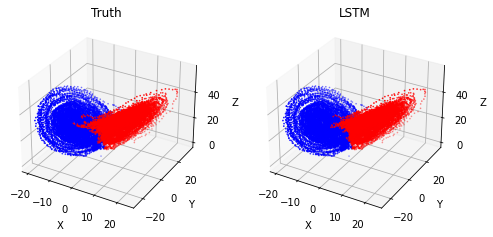

In [19]:
# predict on test data
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

# Define a custom function to evaluate the predictions with multiple metrics
def evaluate_predictions(truth_label, predicted_label):
    accuracy = accuracy_score(truth_label, predicted_label)
    precision = precision_score(truth_label, predicted_label, average='macro')
    recall = recall_score(truth_label, predicted_label, average='macro')
    return accuracy, precision, recall,

# ------------------------------------------------------------
# scatter truth and predict on test data
# use Fuzzy C-means clusetered results as truth
truth_label = np.load('SeqKmeans_label_2center_test.npy')
sol = np.squeeze(np.load('sol_test.npy'))
der = np.squeeze(np.load('der_test.npy'))
X = np.concatenate([sol, der], axis=0).T

# create sequence data
X_new = np.zeros((X.shape[0]-lagtime, sequence_length,X.shape[1],))
for i in range(X.shape[0]-lagtime):
    X_new[i,:,:] = X[i:i+lagtime+1:laginter,:]
# X_new = X_new.reshape(X.shape[0]-lagtime, -1)
print(X_new.shape)
test_data = X_new

# predict
outputs = model(torch.from_numpy(test_data))
_, lstm_label = torch.max(outputs, 1)

# # reverse label 0 - 1
# lstm_label = - lstm_label + 1
accuracy_lstm, precision_lstm, recall_lstm = evaluate_predictions(truth_label, lstm_label)
# roc_auc_score_lstm = roc_auc_score(truth_label, 1 - lstm_classifier.predict_proba(test_data)[:, 1], average='macro')

print("Accuracy lstm:", accuracy_lstm)
print("Precision lstm:", precision_lstm)
print("Recall lstm:", recall_lstm)
# print("ROC_AUC lstm:", roc_auc_score_lstm)


fig1, axes1 = plt.subplots(1, 2, figsize=(8, 4), subplot_kw=dict(projection='3d'))
colors = ['b', 'r', 'g', 'orange']
ncenters = 2
x_data = sol[0, lagtime:]
y_data = sol[1, lagtime:]
z_data = sol[2, lagtime:]

for j in range(ncenters):
    axes1[0].scatter(x_data[truth_label == j], y_data[truth_label == j], z_data[truth_label == j],
               label=f'Regime {j+1}', s=.5, color=colors[j])
axes1[0].set_xlabel('X')
axes1[0].set_ylabel('Y')
axes1[0].set_zlabel('Z')
axes1[0].set_title('Truth')

for j in range(ncenters):
    axes1[1].scatter(x_data[lstm_label == j], y_data[lstm_label == j], z_data[lstm_label == j],
               label=f'Regime {j+1}', s=.5, color=colors[j])
axes1[1].set_xlabel('X')
axes1[1].set_ylabel('Y')
axes1[1].set_zlabel('Z')
axes1[1].set_title('LSTM')

# for j in range(ncenters):
#     axes1[2].scatter(x_data[flstm_label == j], y_data[flstm_label == j], z_data[flstm_label == j],
#                label=f'Regime {j+1}', s=.5, color=colors[j])
# axes1[2].set_xlabel('X')
# axes1[2].set_ylabel('Y')
# axes1[2].set_zlabel('Z')
# axes1[2].set_title('Fuzzy lstm')

plt.subplots_adjust(wspace=0.25)  # Increased the width of intervals among subplots
plt.savefig('LSTM_predict.png', dpi=150)
plt.show()

In [16]:
truth_label = np.load('SeqKmeans_label_2center_test.npy')
truth_label.shape

(19969,)

# 2. Surrogate Model

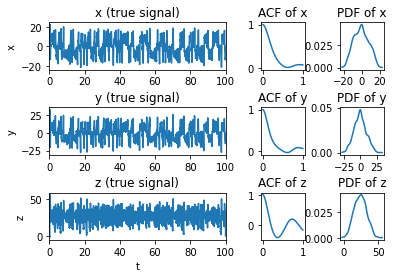

In [7]:
# Truth
x_truth = truth[0, 0, :]
y_truth = truth[1, 0, :]
z_truth = truth[2, 0, :]

Lag = 200

fig = plt.figure()
widths = [8, 2, 2]
heights = [2, 2, 2]
spec = fig.add_gridspec(ncols=3, nrows=3, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.4, hspace=0.8)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[2, 0])
ax4 = fig.add_subplot(spec[0, 1])
ax5 = fig.add_subplot(spec[1, 1])
ax6 = fig.add_subplot(spec[2, 1])
ax7 = fig.add_subplot(spec[0, 2])
ax8 = fig.add_subplot(spec[1, 2])
ax9 = fig.add_subplot(spec[2, 2])

# Subplot for x_truth
sel0 = 0
sel1 = N
ax1.plot(np.arange(0, (N+1) * dt, dt), x_truth)
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_title('x (true signal)')
ax1.set_ylabel('x')

ax2.plot(np.arange(0, (N+1) * dt, dt), y_truth)
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_title('y (true signal)')
ax2.set_ylabel('y')

ax3.plot(np.arange(0, (N+1) * dt, dt), z_truth)
ax3.set_xlim(sel0*dt, sel1*dt)
ax3.set_title('z (true signal)')
ax3.set_ylabel('z')
ax3.set_xlabel('t')

# Subplot for ACF of x_truth
ax4.plot(np.arange(0, Lag * dt, dt), stattools.acf(x_truth, nlags=Lag-1))
ax4.set_title('ACF of x')

ax5.plot(np.arange(0, Lag * dt, dt), stattools.acf(y_truth, nlags=Lag-1))
ax5.set_title('ACF of y')

ax6.plot(np.arange(0, Lag * dt, dt), stattools.acf(z_truth, nlags=Lag-1))
ax6.set_title('ACF of z')

# Subplot for PDF of x_truth
kde = gaussian_kde(x_truth)
xx = np.linspace(np.min(x_truth), np.max(x_truth), 100)
fi = kde.evaluate(xx)
ax7.plot(xx, fi)
ax7.set_title('PDF of x')

kde = gaussian_kde(y_truth)
xx = np.linspace(np.min(y_truth), np.max(y_truth), 100)
fi = kde.evaluate(xx)
ax8.plot(xx, fi)
ax8.set_title('PDF of y')

kde = gaussian_kde(z_truth)
xx = np.linspace(np.min(z_truth), np.max(z_truth), 100)
fi = kde.evaluate(xx)
ax9.plot(xx, fi)
ax9.set_title('PDF of z')
# plt.savefig('../../fig/truesign.png', dpi=150)
plt.show()

## 2.1 Complete Model

Candidate functions:
x, y, z, xy, yz, zx, x^2, y^2, z^2
Model structure (truth):
[[1 1 0 0 0 0 0 0 0]
 [1 1 0 0 0 1 0 0 0]
 [0 0 1 1 0 0 0 0 0]]
Model structure (surrogate model):
[[1 1 1 1 0 1 1 0 0]
 [1 1 1 1 0 1 1 0 0]
 [1 1 1 1 0 1 1 0 0]]
Theta1
 [[-1.00071003e+01  1.01147103e+01 -1.62931734e-04 -9.41635973e-03
   1.01526685e-03  1.71421336e-03]
 [ 2.78017379e+01 -8.75368634e-01 -1.74494596e-02 -1.11934909e-02
  -9.96570642e-01  2.38791363e-02]
 [-3.76156966e-02  3.64484634e-02 -2.67343143e+00  1.01585639e+00
   2.14745932e-03 -1.35442603e-02]]
Sigma1
 [[ 0.18750523  0.         -0.        ]
 [ 0.          0.26158802  0.        ]
 [-0.          0.          0.30409343]]
sigma
 [[ 6.12380977  0.         -0.        ]
 [ 0.          7.23309094  0.        ]
 [-0.          0.          7.79863363]]


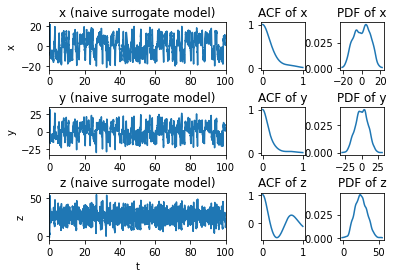

In [8]:
# a Naive Surrogate model 
# Define candidates and true model structure
All_Candidates = np.vstack((x_truth, y_truth, z_truth, x_truth * y_truth, y_truth * z_truth, z_truth * x_truth, x_truth**2, y_truth**2, z_truth**2))

# Remove last point from candidates
All_Candidates = All_Candidates[:, :-1]

True_Model_Structure = np.array([[1, 1, 0, 0, 0, 0, 0, 0, 0],
                                 [1, 1, 0, 0, 0, 1, 0, 0, 0],
                                 [0, 0, 1, 1, 0, 0, 0, 0, 0]], dtype=int)
Surro_Model_Structure = np.array([[1, 1, 1, 1, 0, 1, 1, 0, 0],
                                  [1, 1, 1, 1, 0, 1, 1, 0, 0],
                                  [1, 1, 1, 1, 0, 1, 1, 0, 0]], dtype=int)

print('Candidate functions:')
print('x, y, z, xy, yz, zx, x^2, y^2, z^2')
print('Model structure (truth):')
print(True_Model_Structure)
print('Model structure (surrogate model):')
print(Surro_Model_Structure)

# Parameter estimation of the surrogate mode
num_theta = 18
Theta = np.zeros(num_theta)
Sigma = np.zeros((3, 3))

for _ in range(10):
    for i in range(N - 1):
        M = np.zeros((3, num_theta))
        mj = 0
        for k in range(3):
            M[k, mj] = All_Candidates[0, i]
            M[k, mj+1] = All_Candidates[1, i]
            M[k, mj+2] = All_Candidates[2, i]
            M[k, mj+3] = All_Candidates[3, i]
            M[k, mj+4] = All_Candidates[5, i]
            M[k, mj+5] = All_Candidates[6, i]
            mj += 6
        M = M * dt
        z = np.array([x_truth[i + 1], y_truth[i + 1], z_truth[i + 1]])
        s = np.array([x_truth[i], y_truth[i], z_truth[i]])
        Sigma += np.outer(z - M @ Theta - s, z - M @ Theta - s)

    Sigma = Sigma / (N - 1) * np.eye(3)
    invSigma = np.linalg.inv(Sigma)
    D = np.zeros((num_theta, num_theta))
    c = np.zeros(num_theta)
    
    for i in range(N - 1):
        M = np.zeros((3, num_theta))
        mj = 0
        for k in range(3):
            M[k, mj] = All_Candidates[0, i]
            M[k, mj+1] = All_Candidates[1, i]
            M[k, mj+2] = All_Candidates[2, i]
            M[k, mj+3] = All_Candidates[3, i]
            M[k, mj+4] = All_Candidates[5, i]
            M[k, mj+5] = All_Candidates[6, i]
            mj += 6
        M = M * dt
        z = np.array([x_truth[i + 1], y_truth[i + 1], z_truth[i + 1]])
        s = np.array([x_truth[i], y_truth[i], z_truth[i]])
        D += M.T @ invSigma @ M
        c += M.T @ invSigma @ (z - s)

    D = D / (N - 1)
    c = c / (N - 1)
    Theta1 = np.linalg.solve(D, c)
#     lambda_val = np.linalg.inv(H @ np.linalg.inv(D) @ H.T) @ (H @ np.linalg.inv(D) @ c - g)
#     Theta1_Constraint = np.linalg.solve(D, c - H.T @ lambda_val)

Sigma1 = Sigma
print('Theta1\n',np.reshape(Theta1, (3,6)))
print('Sigma1\n',Sigma1)
print('sigma\n',(Sigma1/dt)**0.5)

x1 = np.zeros(N)
y1 = np.zeros(N)
z1 = np.zeros(N)
x1[0], y1[0], z1[0] = y0

np.random.seed(10)
for i in range(1, N):
    x1[i] = x1[i - 1] + (Theta1[0] * x1[i - 1] + Theta1[1] * y1[i - 1] + Theta1[2] * z1[i - 1] + Theta1[3] * x1[i-1]*y1[i - 1] + Theta1[4] * x1[i-1]*z1[i - 1] + Theta1[5] * x1[i-1]**2) * dt + np.sqrt(Sigma1[0, 0] / dt) * np.sqrt(dt) * np.random.randn()
    y1[i] = y1[i - 1] + (Theta1[6] * x1[i - 1] + Theta1[7] * y1[i - 1] + Theta1[8] * z1[i - 1] + Theta1[9] * x1[i-1]*y1[i - 1] + Theta1[10] * x1[i-1]*z1[i - 1] + Theta1[11] * x1[i-1]**2) * dt + np.sqrt(Sigma1[1, 1] / dt) * np.sqrt(dt) * np.random.randn()
    z1[i] = z1[i - 1] + (Theta1[12] * x1[i - 1] + Theta1[13] * y1[i - 1] + Theta1[14] * z1[i - 1] + Theta1[15] * x1[i-1]*y1[i - 1] + Theta1[16] * x1[i-1]*z1[i - 1] + Theta1[17] * x1[i-1]**2) * dt + np.sqrt(Sigma1[2, 2] / dt) * np.sqrt(dt) * np.random.randn()

# plot
fig = plt.figure()
widths = [8, 2, 2]
heights = [2, 2, 2]
spec = fig.add_gridspec(ncols=3, nrows=3, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.4, hspace=0.8)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[2, 0])
ax4 = fig.add_subplot(spec[0, 1])
ax5 = fig.add_subplot(spec[1, 1])
ax6 = fig.add_subplot(spec[2, 1])
ax7 = fig.add_subplot(spec[0, 2])
ax8 = fig.add_subplot(spec[1, 2])
ax9 = fig.add_subplot(spec[2, 2])

# Subplot for x_1
sel0 = 0
sel1 = N
ax1.plot(np.arange(0, N * dt, dt), x1)
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_title('x (naive surrogate model)')
ax1.set_ylabel('x')

ax2.plot(np.arange(0, N * dt, dt), y1)
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_title('y (naive surrogate model)')
ax2.set_ylabel('y')

ax3.plot(np.arange(0, N * dt, dt), z1)
ax3.set_xlim(sel0*dt, sel1*dt)
ax3.set_title('z (naive surrogate model)')
ax3.set_ylabel('z')
ax3.set_xlabel('t')

# Subplot for ACF of x_1
ax4.plot(np.arange(0, Lag * dt, dt), stattools.acf(x1, nlags=Lag-1))
ax4.set_title('ACF of x')

ax5.plot(np.arange(0, Lag * dt, dt), stattools.acf(y1, nlags=Lag-1))
ax5.set_title('ACF of y')

ax6.plot(np.arange(0, Lag * dt, dt), stattools.acf(z1, nlags=Lag-1))
ax6.set_title('ACF of z')

# Subplot for PDF of x_1
kde = gaussian_kde(x1)
xx = np.linspace(np.min(x1), np.max(x1), 100)
fi = kde.evaluate(xx)
ax7.plot(xx, fi)
ax7.set_title('PDF of x')

kde = gaussian_kde(y1)
xx = np.linspace(np.min(y1), np.max(y1), 100)
fi = kde.evaluate(xx)
ax8.plot(xx, fi)
ax8.set_title('PDF of y')

kde = gaussian_kde(z1)
xx = np.linspace(np.min(z1), np.max(z1), 100)
fi = kde.evaluate(xx)
ax9.plot(xx, fi)
ax9.set_title('PDF of z')
# plt.savefig('../../fig/NaiveSurroModel.png', dpi=150)
plt.show()

Candidate functions:
x, y, z, xy, yz, zx, x^2, y^2, z^2
Model structure (truth):
[[1 1 0 0 0 0 0 0 0]
 [1 1 0 0 0 1 0 0 0]
 [0 0 1 1 0 0 0 0 0]]
Model structure (Physics constrained surrogate model):
[[1 1 1 1 0 1 1 0 0]
 [1 1 1 1 0 1 1 0 0]
 [1 1 1 1 0 1 1 0 0]]
Theta1_Constraint
 [[-1.00052475e+01  1.01145424e+01  4.86428612e-03 -9.31045269e-03
   9.53958361e-04 -6.97587325e-18]
 [ 2.80982056e+01 -9.42358811e-01 -1.18852055e-03  1.24093874e-17
  -1.00420402e+00  9.31045269e-03]
 [ 5.05628463e-02  1.37501866e-02 -2.68143250e+00  1.00420402e+00
   4.81038884e-19 -9.53958361e-04]]
Sigma1
 [[ 0.18750523  0.         -0.        ]
 [ 0.          0.26158802  0.        ]
 [-0.          0.          0.30409343]]
sigma
 [[ 6.12380977  0.         -0.        ]
 [ 0.          7.23309094  0.        ]
 [-0.          0.          7.79863363]]


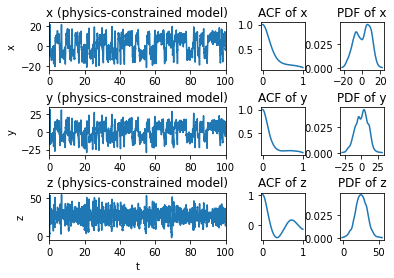

In [14]:
# Surrogate model with Physics Constraints
True_Model_Structure = np.array([[1, 1, 0, 0, 0, 0, 0, 0, 0],
                                 [1, 1, 0, 0, 0, 1, 0, 0, 0],
                                 [0, 0, 1, 1, 0, 0, 0, 0, 0]], dtype=int)
Surro_Model_Structure = np.array([[1, 1, 1, 1, 0, 1, 1, 0, 0],
                                  [1, 1, 1, 1, 0, 1, 1, 0, 0],
                                  [1, 1, 1, 1, 0, 1, 1, 0, 0]], dtype=int)

print('Candidate functions:')
print('x, y, z, xy, yz, zx, x^2, y^2, z^2')
print('Model structure (truth):')
print(True_Model_Structure)
print('Model structure (Physics constrained surrogate model):')
print(Surro_Model_Structure)

# Parameter estimation of the surrogate model
num_theta = 18
num_constraints = 6
H = np.zeros((num_constraints, num_theta))
H[0, [10, 15]] = 1
H[1, [4, 17]] = 1
H[2, [3, 11]] = 1
H[3, 5] = 1
H[4, 9] = 1
H[5, 16] = 1

g = np.zeros((num_constraints,1))
Theta = np.zeros(num_theta)
Sigma = np.zeros((3, 3))

for _ in range(10):
    for i in range(N - 1):
        M = np.zeros((3, num_theta))
        mj = 0
        for k in range(3):
            M[k, mj] = All_Candidates[0, i]
            M[k, mj+1] = All_Candidates[1, i]
            M[k, mj+2] = All_Candidates[2, i]
            M[k, mj+3] = All_Candidates[3, i]
            M[k, mj+4] = All_Candidates[5, i]
            M[k, mj+5] = All_Candidates[6, i]
            mj += 6
        M = M * dt
        z = np.array([x_truth[i + 1], y_truth[i + 1], z_truth[i + 1]])
        s = np.array([x_truth[i], y_truth[i], z_truth[i]])
        Sigma += np.outer(z - M @ Theta - s, z - M @ Theta - s)

    Sigma = Sigma / (N - 1) * np.eye(3)
    invSigma = np.linalg.inv(Sigma)
    D = np.zeros((num_theta, num_theta))
    c = np.zeros((num_theta,1))
    
    for i in range(N - 1):
        M = np.zeros((3, num_theta))
        mj = 0
        for k in range(3):
            M[k, mj] = All_Candidates[0, i]
            M[k, mj+1] = All_Candidates[1, i]
            M[k, mj+2] = All_Candidates[2, i]
            M[k, mj+3] = All_Candidates[3, i]
            M[k, mj+4] = All_Candidates[5, i]
            M[k, mj+5] = All_Candidates[6, i]
            mj += 6
        M = M * dt
        z = np.array([x_truth[i + 1], y_truth[i + 1], z_truth[i + 1]])[:,None]
        s = np.array([x_truth[i], y_truth[i], z_truth[i]])[:,None]
        D += M.T @ invSigma @ M
        c += M.T @ invSigma @ (z - s)

    D = D / (N - 1)
    c = c / (N - 1)
    Theta1 = np.linalg.solve(D, c)
    lambda_val = np.linalg.inv(H @ np.linalg.inv(D) @ H.T) @ (H @ np.linalg.inv(D) @ c - g)
    Theta1_Constraint = np.linalg.solve(D, c - H.T @ lambda_val)

Sigma1 = Sigma
print('Theta1_Constraint\n',np.reshape(Theta1_Constraint, (3,6)))
print('Sigma1\n',Sigma1)
print('sigma\n',(Sigma1/dt)**0.5)

x1 = np.zeros(N)
y1 = np.zeros(N)
z1 = np.zeros(N)
x1[0] = 0
y1[0] = 0
z1[0] = 0

np.random.seed(10)
for i in range(1, N):
    x1[i] = x1[i - 1] + (Theta1_Constraint[0] * x1[i - 1] + Theta1_Constraint[1] * y1[i - 1] + Theta1_Constraint[2] * z1[i - 1] + Theta1_Constraint[3] * x1[i-1]*y1[i - 1] + Theta1_Constraint[4] * x1[i-1]*z1[i - 1] + Theta1_Constraint[5] * x1[i-1]**2) * dt + np.sqrt(Sigma1[0, 0] / dt) * np.sqrt(dt) * np.random.randn()
    y1[i] = y1[i - 1] + (Theta1_Constraint[6] * x1[i - 1] + Theta1_Constraint[7] * y1[i - 1] + Theta1_Constraint[8] * z1[i - 1] + Theta1_Constraint[9] * x1[i-1]*y1[i - 1] + Theta1_Constraint[10] * x1[i-1]*z1[i - 1] + Theta1_Constraint[11] * x1[i-1]**2) * dt + np.sqrt(Sigma1[1, 1] / dt) * np.sqrt(dt) * np.random.randn()
    z1[i] = z1[i - 1] + (Theta1_Constraint[12] * x1[i - 1] + Theta1_Constraint[13] * y1[i - 1] + Theta1_Constraint[14] * z1[i - 1] + Theta1_Constraint[15] * x1[i-1]*y1[i - 1] + Theta1_Constraint[16] * x1[i-1]*z1[i - 1] + Theta1_Constraint[17] * x1[i-1]**2) * dt + np.sqrt(Sigma1[2, 2] / dt) * np.sqrt(dt) * np.random.randn()

# plot
fig = plt.figure()
widths = [8, 2, 2]
heights = [2, 2, 2]
spec = fig.add_gridspec(ncols=3, nrows=3, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.4, hspace=0.8)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[2, 0])
ax4 = fig.add_subplot(spec[0, 1])
ax5 = fig.add_subplot(spec[1, 1])
ax6 = fig.add_subplot(spec[2, 1])
ax7 = fig.add_subplot(spec[0, 2])
ax8 = fig.add_subplot(spec[1, 2])
ax9 = fig.add_subplot(spec[2, 2])

# Subplot for x_1
sel0 = 0
sel1 = N
ax1.plot(np.arange(0, N * dt, dt), x1)
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_title('x (physics-constrained model)')
ax1.set_ylabel('x')

ax2.plot(np.arange(0, N * dt, dt), y1)
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_title('y (physics-constrained model)')
ax2.set_ylabel('y')

ax3.plot(np.arange(0, N * dt, dt), z1)
ax3.set_xlim(sel0*dt, sel1*dt)
ax3.set_title('z (physics-constrained model)')
ax3.set_ylabel('z')
ax3.set_xlabel('t')

# Subplot for ACF of x_1
ax4.plot(np.arange(0, Lag * dt, dt), stattools.acf(x1, nlags=Lag-1))
ax4.set_title('ACF of x')

ax5.plot(np.arange(0, Lag * dt, dt), stattools.acf(y1, nlags=Lag-1))
ax5.set_title('ACF of y')

ax6.plot(np.arange(0, Lag * dt, dt), stattools.acf(z1, nlags=Lag-1))
ax6.set_title('ACF of z')

# Subplot for PDF of x_1
kde = gaussian_kde(x1)
xx = np.linspace(np.min(x1), np.max(x1), 100)
fi = kde.evaluate(xx)
ax7.plot(xx, fi)
ax7.set_title('PDF of x')

kde = gaussian_kde(y1)
xx = np.linspace(np.min(y1), np.max(y1), 100)
fi = kde.evaluate(xx)
ax8.plot(xx, fi)
ax8.set_title('PDF of y')

kde = gaussian_kde(z1)
xx = np.linspace(np.min(z1), np.max(z1), 100)
fi = kde.evaluate(xx)
ax9.plot(xx, fi)
ax9.set_title('PDF of z')
plt.savefig('../../fig/PhysConstrModel.png', dpi=150)
plt.show()


In [106]:
# Surrogate model with Model Identification
from scipy.linalg import det

# Parameters
threshold = a0 # threshold of causation entropy
L = 9

# Compute time derivatives
x_derivative = np.diff(x_truth) / dt
y_derivative = np.diff(y_truth) / dt
z_derivative = np.diff(z_truth) / dt

# Calculate causation entropy matrix (CEM) based on the Gaussian approximation
CEM = np.zeros((3, L))
for k in range(3):
    if k == 0:
        All_Variables = np.vstack((All_Candidates, x_derivative))
    elif k == 1:
        All_Variables = np.vstack((All_Candidates, y_derivative))
    elif k == 2:
        All_Variables = np.vstack((All_Candidates, z_derivative))
    
    All_Cov = np.cov(All_Variables)
    
    for i in range(L):
        RXY = np.delete(np.delete(All_Cov, i, axis=0), i, axis=1)
        RY = np.delete(np.delete(All_Cov, [i, L], axis=0), [i, L], axis=1)
        RXYZ = All_Cov
        RYZ = All_Cov[:L, :L]

        CEM[k, i] = 0.5 * (np.log(det(RXY)) - np.log(det(RY)) - np.log(det(RXYZ)) + np.log(det(RYZ)))
        
CEM_Original = CEM
CEM_indicator = (CEM_Original > threshold).astype(int)

print('Candidate functions:')
print('x, y, z, xy, yz, zx, x^2, y^2, z^2')
print('Model structure (truth):')
print(True_Model_Structure)
print('Model structure (identified model):')
print(CEM_indicator)
print('CEM_Original',CEM_Original)

Candidate functions:
x, y, z, xy, yz, zx, x^2, y^2, z^2
Model structure (truth):
[[1 1 0 0 0 0 0 0 0]
 [1 1 0 0 0 1 0 0 0]
 [0 0 1 1 0 0 0 0 0]]
Model structure (identified model):
[[1 1 0 0 0 0 0 0 0]
 [1 1 0 0 0 1 0 0 0]
 [0 0 1 1 0 0 0 0 0]]


In [109]:
CEM_Original

array([[6.68507710e-03, 1.54283778e-02, 4.31172697e-06, 9.81876457e-07,
        3.54056613e-06, 2.91563600e-06, 2.23156416e-07, 2.01713634e-05,
        1.08932921e-06],
       [5.25252324e-02, 1.07612324e-04, 2.01870079e-05, 9.65581222e-07,
        7.19089371e-07, 8.74581029e-02, 2.60603953e-05, 3.98048579e-05,
        3.05745081e-06],
       [1.17970845e-05, 1.36319463e-05, 1.36717030e-03, 1.57702119e-02,
        1.16415665e-05, 2.02346545e-05, 1.94383571e-07, 7.36575913e-05,
        1.09647942e-07]])

Theta1_Constraint
 [-9.96382287 10.10533932 28.06748052 -0.93427867 -1.00362259 -2.68382407
  1.00362259]
Sigma1
 [[ 0.18750523  0.         -0.        ]
 [ 0.          0.26158802  0.        ]
 [-0.          0.          0.30409343]]


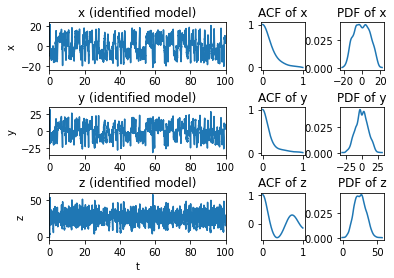

In [108]:
# Parameter estimation of the surrogate model
H = np.zeros(7)
H[[4, 6]] = 1
H = H[None, :]
g = 0
Theta = np.zeros(7)
Sigma = np.zeros((3, 3))

for _ in range(10):
    for i in range(N - 1):
        M = np.zeros((3, 7))
        M[0, 0] = All_Candidates[0, i]
        M[0, 1] = All_Candidates[1, i]
        M[1, 2] = All_Candidates[0, i]
        M[1, 3] = All_Candidates[1, i]
        M[1, 4] = All_Candidates[5, i]
        M[2, 5] = All_Candidates[2, i]
        M[2, 6] = All_Candidates[3, i]
        M = M * dt
        z = np.array([x_truth[i + 1], y_truth[i + 1], z_truth[i + 1]])
        s = np.array([x_truth[i], y_truth[i], z_truth[i]])
        Sigma += np.outer(z - M @ Theta - s, z - M @ Theta - s)

    Sigma = Sigma / (N - 1) * np.eye(3)
    invSigma = np.linalg.inv(Sigma)
    D = np.zeros((7, 7))
    c = np.zeros(7)
    
    for i in range(N - 1):
        M = np.zeros((3, 7))
        M[0, 0] = All_Candidates[0, i]
        M[0, 1] = All_Candidates[1, i]
        M[1, 2] = All_Candidates[0, i]
        M[1, 3] = All_Candidates[1, i]
        M[1, 4] = All_Candidates[5, i]
        M[2, 5] = All_Candidates[2, i]
        M[2, 6] = All_Candidates[3, i]
        M = M * dt
        z = np.array([x_truth[i + 1], y_truth[i + 1], z_truth[i + 1]])
        s = np.array([x_truth[i], y_truth[i], z_truth[i]])
        D += M.T @ invSigma @ M
        c += M.T @ invSigma @ (z - s)

    D = D / (N - 1)
    c = c / (N - 1)
    Theta1 = np.linalg.solve(D, c)
    lambda_val = np.linalg.inv(H @ np.linalg.inv(D) @ H.T) @ (H @ np.linalg.inv(D) @ c - g)
    Theta1_Constraint = np.linalg.solve(D, c - H.T @ lambda_val)

Sigma1 = Sigma

print('Theta1_Constraint\n',Theta1_Constraint)
print('Sigma1\n',Sigma1)
print('sigma\n',(Sigma1/dt)**0.5)

x1 = np.zeros(N)
y1 = np.zeros(N)
z1 = np.zeros(N)
x1[0] = 0
y1[0] = 0
z1[0] = 0

np.random.seed(10)
for i in range(1, N):
    x1[i] = x1[i - 1] + (Theta1_Constraint[0] * x1[i - 1] + Theta1_Constraint[1] * y1[i - 1]) * dt + np.sqrt(Sigma1[0, 0] / dt) * np.sqrt(dt) * np.random.randn()
    y1[i] = y1[i - 1] + (Theta1_Constraint[2] * x1[i - 1] + Theta1_Constraint[3] * y1[i - 1] + Theta1_Constraint[4] * z1[i - 1] * x1[i - 1]) * dt + np.sqrt(Sigma1[1, 1] / dt) * np.sqrt(dt) * np.random.randn()
    z1[i] = z1[i - 1] + (Theta1_Constraint[5] * z1[i - 1] + Theta1_Constraint[6] * x1[i - 1] * y1[i - 1]) * dt + np.sqrt(Sigma1[2, 2] / dt) * np.sqrt(dt) * np.random.randn()

# plot
fig = plt.figure()
widths = [8, 2, 2]
heights = [2, 2, 2]
spec = fig.add_gridspec(ncols=3, nrows=3, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.4, hspace=0.8)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[2, 0])
ax4 = fig.add_subplot(spec[0, 1])
ax5 = fig.add_subplot(spec[1, 1])
ax6 = fig.add_subplot(spec[2, 1])
ax7 = fig.add_subplot(spec[0, 2])
ax8 = fig.add_subplot(spec[1, 2])
ax9 = fig.add_subplot(spec[2, 2])

# Subplot for x_1
sel0 = 0
sel1 = N
ax1.plot(np.arange(0, N * dt, dt), x1)
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_title('x (identified model)')
ax1.set_ylabel('x')

ax2.plot(np.arange(0, N * dt, dt), y1)
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_title('y (identified model)')
ax2.set_ylabel('y')

ax3.plot(np.arange(0, N * dt, dt), z1)
ax3.set_xlim(sel0*dt, sel1*dt)
ax3.set_title('z (identified model)')
ax3.set_ylabel('z')
ax3.set_xlabel('t')

# Subplot for ACF of x_1
ax4.plot(np.arange(0, Lag * dt, dt), stattools.acf(x1, nlags=Lag-1))
ax4.set_title('ACF of x')

ax5.plot(np.arange(0, Lag * dt, dt), stattools.acf(y1, nlags=Lag-1))
ax5.set_title('ACF of y')

ax6.plot(np.arange(0, Lag * dt, dt), stattools.acf(z1, nlags=Lag-1))
ax6.set_title('ACF of z')

# Subplot for PDF of x_1
kde = gaussian_kde(x1)
xx = np.linspace(np.min(x1), np.max(x1), 100)
fi = kde.evaluate(xx)
ax7.plot(xx, fi)
ax7.set_title('PDF of x')

kde = gaussian_kde(y1)
xx = np.linspace(np.min(y1), np.max(y1), 100)
fi = kde.evaluate(xx)
ax8.plot(xx, fi)
ax8.set_title('PDF of y')

kde = gaussian_kde(z1)
xx = np.linspace(np.min(z1), np.max(z1), 100)
fi = kde.evaluate(xx)
ax9.plot(xx, fi)
ax9.set_title('PDF of z')
plt.savefig('../../fig/CEModel.png', dpi=150)
plt.show()


## 2.2 Surrogate Model of Regimes

(19969,)


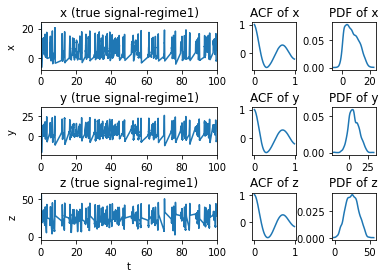

In [32]:
# truth regime1
# load label data
label = np.load('SeqKmeans_label_2center_naturerun.npy')
print(label.shape)

# Truth
x_truth = truth[0, 0, lagtime:]
y_truth = truth[1, 0, lagtime:]
z_truth = truth[2, 0, lagtime:]

# Define candidates and true model structure
All_Candidates = np.vstack((x_truth, y_truth, z_truth, x_truth * y_truth, y_truth * z_truth, z_truth * x_truth, x_truth**2, y_truth**2, z_truth**2))

# Partition data into 2 regimes
bool_label = label == 1
x_truth1 = x_truth[bool_label]
x_truth2 = x_truth[~bool_label]
y_truth1 = y_truth[bool_label]
y_truth2 = y_truth[~bool_label]
z_truth1 = z_truth[bool_label]
z_truth2 = z_truth[~bool_label]
All_Candidates1 = All_Candidates[:,bool_label]
All_Candidates2 = All_Candidates[:,~bool_label]
indt1 = np.where(label==1)[0]
indt2 = np.where(label==0)[0]

# plot
fig = plt.figure()
widths = [8, 2, 2]
heights = [2, 2, 2]
spec = fig.add_gridspec(ncols=3, nrows=3, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.4, hspace=0.8)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[2, 0])
ax4 = fig.add_subplot(spec[0, 1])
ax5 = fig.add_subplot(spec[1, 1])
ax6 = fig.add_subplot(spec[2, 1])
ax7 = fig.add_subplot(spec[0, 2])
ax8 = fig.add_subplot(spec[1, 2])
ax9 = fig.add_subplot(spec[2, 2])

# Subplot for x_truth
sel0 = 0
sel1 = N
ax1.plot(indt1.astype(float)*dt, x_truth1)
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_title('x (true signal-regime1)')
ax1.set_ylabel('x')

ax2.plot(indt1.astype(float)*dt, y_truth1)
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_title('y (true signal-regime1)')
ax2.set_ylabel('y')

ax3.plot(indt1.astype(float)*dt, z_truth1)
ax3.set_xlim(sel0*dt, sel1*dt)
ax3.set_title('z (true signal-regime1)')
ax3.set_ylabel('z')
ax3.set_xlabel('t')

# Remove last point from candidates
All_Candidates1 = All_Candidates1[:, :-1]
All_Candidates2 = All_Candidates2[:, :-1]
indt1 = indt1[:-1]
indt2 = indt2[:-1]

ind_cut1 = [indt1[0]]
for i in range(indt1.shape[0]-1):
    if (indt1[i+1] - indt1[i]) > 1:
        ind_cut1.append(indt1[i+1])
# Use numpy.in1d to create a boolean mask for elements in arr that are in elements_to_find
mask = np.in1d(indt1, ind_cut1)
# Use numpy.where to get the indices where the mask is True
iind_cut1 = np.where(mask)[0]
iind_cut1 = np.append(iind_cut1, indt1.shape[0])

ind_cut2 = [indt2[0]]
for i in range(indt2.shape[0]-1):
    if (indt2[i+1] - indt2[i]) > 1:
        ind_cut2.append(indt2[i+1])
# Use numpy.in1d to create a boolean mask for elements in arr that are in elements_to_find
mask = np.in1d(indt2, ind_cut2)
# Use numpy.where to get the indices where the mask is True
iind_cut2 = np.where(mask)[0]
iind_cut2 = np.append(iind_cut2, indt2.shape[0])

Lag = 200

# Subplot for ACF of x_truth
# calculate mean ACF
indlag = []
acfx = 0
acfy = 0
acfz = 0
nacf = 0
for i in range(1, iind_cut1.shape[0]):
    if (iind_cut1[i] - iind_cut1[i-1]) > Lag:
        indlag.append(iind_cut1[i-1])
        acfx += stattools.acf(x_truth1[iind_cut1[i-1]:iind_cut1[i]], nlags=Lag-1)
        acfy += stattools.acf(y_truth1[iind_cut1[i-1]:iind_cut1[i]], nlags=Lag-1)
        acfz += stattools.acf(z_truth1[iind_cut1[i-1]:iind_cut1[i]], nlags=Lag-1)
        nacf += 1
acfx = acfx / nacf
acfy = acfy / nacf
acfz = acfz / nacf

ax4.plot(np.arange(0, Lag * dt, dt), acfx)
ax4.set_title('ACF of x')

ax5.plot(np.arange(0, Lag * dt, dt), acfy)
ax5.set_title('ACF of y')

ax6.plot(np.arange(0, Lag * dt, dt), acfz)
ax6.set_title('ACF of z')

# Subplot for PDF of x_truth
kde = gaussian_kde(x_truth1)
xx = np.linspace(np.min(x_truth1), np.max(x_truth1), 100)
fi = kde.evaluate(xx)
ax7.plot(xx, fi)
ax7.set_title('PDF of x')

kde = gaussian_kde(y_truth1)
xx = np.linspace(np.min(y_truth1), np.max(y_truth1), 100)
fi = kde.evaluate(xx)
ax8.plot(xx, fi)
ax8.set_title('PDF of y')

kde = gaussian_kde(z_truth1)
xx = np.linspace(np.min(z_truth1), np.max(z_truth1), 100)
fi = kde.evaluate(xx)
ax9.plot(xx, fi)
ax9.set_title('PDF of z')
# plt.savefig('../../fig/truesign_regm1.png', dpi=150)
plt.show()

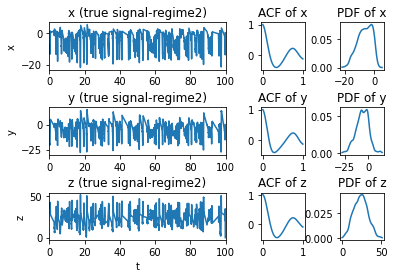

In [18]:
# truth regime2
indt2 = np.where(label==0)[0]

fig = plt.figure()
widths = [8, 2, 2]
heights = [2, 2, 2]
spec = fig.add_gridspec(ncols=3, nrows=3, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.4, hspace=0.8)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[2, 0])
ax4 = fig.add_subplot(spec[0, 1])
ax5 = fig.add_subplot(spec[1, 1])
ax6 = fig.add_subplot(spec[2, 1])
ax7 = fig.add_subplot(spec[0, 2])
ax8 = fig.add_subplot(spec[1, 2])
ax9 = fig.add_subplot(spec[2, 2])

# Subplot for x_truth
sel0 = 0
sel1 = N
ax1.plot(indt2.astype(float)*dt, x_truth2)
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_title('x (true signal-regime2)')
ax1.set_ylabel('x')

ax2.plot(indt2.astype(float)*dt, y_truth2)
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_title('y (true signal-regime2)')
ax2.set_ylabel('y')

ax3.plot(indt2.astype(float)*dt, z_truth2)
ax3.set_xlim(sel0*dt, sel1*dt)
ax3.set_title('z (true signal-regime2)')
ax3.set_ylabel('z')
ax3.set_xlabel('t')

# Subplot for ACF of x_truth
# calculate mean ACF
indlag = []
acfx = 0
acfy = 0
acfz = 0
nacf = 0
for i in range(1, iind_cut2.shape[0]):
    if (iind_cut2[i] - iind_cut2[i-1]) > Lag:
        indlag.append(iind_cut2[i-1])
        acfx += stattools.acf(x_truth2[iind_cut2[i-1]:iind_cut2[i]], nlags=Lag-1)
        acfy += stattools.acf(y_truth2[iind_cut2[i-1]:iind_cut2[i]], nlags=Lag-1)
        acfz += stattools.acf(z_truth2[iind_cut2[i-1]:iind_cut2[i]], nlags=Lag-1)
        nacf += 1
acfx = acfx / nacf
acfy = acfy / nacf
acfz = acfz / nacf

ax4.plot(np.arange(0, Lag * dt, dt), acfx)
ax4.set_title('ACF of x')

ax5.plot(np.arange(0, Lag * dt, dt), acfy)
ax5.set_title('ACF of y')

ax6.plot(np.arange(0, Lag * dt, dt), acfz)
ax6.set_title('ACF of z')

# Subplot for PDF of x_truth
kde = gaussian_kde(x_truth2)
xx = np.linspace(np.min(x_truth2), np.max(x_truth2), 100)
fi = kde.evaluate(xx)
ax7.plot(xx, fi)
ax7.set_title('PDF of x')

kde = gaussian_kde(y_truth2)
xx = np.linspace(np.min(y_truth2), np.max(y_truth2), 100)
fi = kde.evaluate(xx)
ax8.plot(xx, fi)
ax8.set_title('PDF of y')

kde = gaussian_kde(z_truth2)
xx = np.linspace(np.min(z_truth2), np.max(z_truth2), 100)
fi = kde.evaluate(xx)
ax9.plot(xx, fi)
ax9.set_title('PDF of z')
# plt.savefig('../../fig/truesign_regm2.png', dpi=150)
plt.show()

Candidate functions:
x, y, z, xy, yz, zx, x^2, y^2, z^2
Model structure (surrogate model):
[[1 1 1 1 0 1 1 0 0]
 [1 1 1 1 0 1 1 0 0]
 [1 1 1 1 0 1 1 0 0]]
Theta1
 [[-12.28800391   9.83738005   1.05714421  -0.10674073  -0.23818613
    0.67600988]
 [ 22.42913313  -3.15174113   3.09327234  -0.14195201  -1.65406303
    1.7430666 ]
 [  1.427412     1.17354222  -3.67293687   1.01356401   0.21139343
   -0.52910194]]
Sigma1
 [[ 0.11082379  0.          0.        ]
 [ 0.          0.34885638 -0.        ]
 [ 0.         -0.          0.34167005]]
sigma
 [[ 4.70794624  0.          0.        ]
 [ 0.          8.35292015 -0.        ]
 [ 0.         -0.          8.26643877]]


<ipython-input-19-a80f2124c224>:75: RuntimeWarning: overflow encountered in double_scalars
  x1[i] = x1[i - 1] + (Theta1[0] * x1[i - 1] + Theta1[1] * y1[i - 1] + Theta1[2] * z1[i - 1] + Theta1[3] * x1[i-1]*y1[i - 1] + Theta1[4] * x1[i-1]*z1[i - 1] + Theta1[5] * x1[i-1]**2) * dt + np.sqrt(Sigma1[0, 0] / dt) * np.sqrt(dt) * np.random.randn()
<ipython-input-19-a80f2124c224>:75: RuntimeWarning: invalid value encountered in double_scalars
  x1[i] = x1[i - 1] + (Theta1[0] * x1[i - 1] + Theta1[1] * y1[i - 1] + Theta1[2] * z1[i - 1] + Theta1[3] * x1[i-1]*y1[i - 1] + Theta1[4] * x1[i-1]*z1[i - 1] + Theta1[5] * x1[i-1]**2) * dt + np.sqrt(Sigma1[0, 0] / dt) * np.sqrt(dt) * np.random.randn()
<ipython-input-19-a80f2124c224>:76: RuntimeWarning: overflow encountered in double_scalars
  y1[i] = y1[i - 1] + (Theta1[6] * x1[i - 1] + Theta1[7] * y1[i - 1] + Theta1[8] * z1[i - 1] + Theta1[9] * x1[i-1]*y1[i - 1] + Theta1[10] * x1[i-1]*z1[i - 1] + Theta1[11] * x1[i-1]**2) * dt + np.sqrt(Sigma1[1, 1] / dt) *

ValueError: array must not contain infs or NaNs

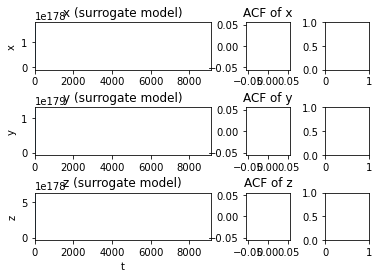

In [19]:
# # a Naive Surrogate model 
# Surro_Model_Structure = np.array([[1, 1, 1, 1, 0, 1, 1, 0, 0],
#                                   [1, 1, 1, 1, 0, 1, 1, 0, 0],
#                                   [1, 1, 1, 1, 0, 1, 1, 0, 0]], dtype=int)

# print('Candidate functions:')
# print('x, y, z, xy, yz, zx, x^2, y^2, z^2')
# print('Model structure (surrogate model):')
# print(Surro_Model_Structure)

# # Parameter estimation of the surrogate mode
# num_theta = 18
# Theta = np.zeros(num_theta)
# Sigma = np.zeros((3, 3))

# for _ in range(10):
#     for i in range(All_Candidates1.shape[1]):
#         M = np.zeros((3, num_theta))
#         mj = 0
#         for k in range(3):
#             M[k, mj] = All_Candidates1[0, i]
#             M[k, mj+1] = All_Candidates1[1, i]
#             M[k, mj+2] = All_Candidates1[2, i]
#             M[k, mj+3] = All_Candidates1[3, i]
#             M[k, mj+4] = All_Candidates1[5, i]
#             M[k, mj+5] = All_Candidates1[6, i]
#             mj += 6
#         M = M * dt
#         z = np.array([x_truth1[i + 1], y_truth1[i + 1], z_truth1[i + 1]])
#         s = np.array([x_truth1[i], y_truth1[i], z_truth1[i]])
#         Sigma += np.outer(z - M @ Theta - s, z - M @ Theta - s)

#     Sigma = Sigma / (N - 1) * np.eye(3)
#     invSigma = np.linalg.inv(Sigma)
#     D = np.zeros((num_theta, num_theta))
#     c = np.zeros(num_theta)
    
#     for i in range(All_Candidates1.shape[1]):
#         M = np.zeros((3, num_theta))
#         mj = 0
#         for k in range(3):
#             M[k, mj] = All_Candidates1[0, i]
#             M[k, mj+1] = All_Candidates1[1, i]
#             M[k, mj+2] = All_Candidates1[2, i]
#             M[k, mj+3] = All_Candidates1[3, i]
#             M[k, mj+4] = All_Candidates1[5, i]
#             M[k, mj+5] = All_Candidates1[6, i]
#             mj += 6
#         M = M * dt
#         z = np.array([x_truth1[i + 1], y_truth1[i + 1], z_truth1[i + 1]])
#         s = np.array([x_truth1[i], y_truth1[i], z_truth1[i]])
#         D += M.T @ invSigma @ M
#         c += M.T @ invSigma @ (z - s)

#     D = D / (N - 1)
#     c = c / (N - 1)
#     Theta1 = np.linalg.solve(D, c)
# #     lambda_val = np.linalg.inv(H @ np.linalg.inv(D) @ H.T) @ (H @ np.linalg.inv(D) @ c - g)
# #     Theta1_Constraint = np.linalg.solve(D, c - H.T @ lambda_val)

# Sigma1 = Sigma
# print('Theta1\n',np.reshape(Theta1, (3,6)))
# print('Sigma1\n',Sigma1)
# print('sigma\n',(Sigma1/dt)**0.5)

# N=All_Candidates1.shape[1]
# x1 = np.zeros(N)
# y1 = np.zeros(N)
# z1 = np.zeros(N)
# x1[0], y1[0], z1[0] = x_truth1[0], y_truth1[0], z_truth1[0]

# np.random.seed(10)
# for i in range(1, N):
#     dt = indt1[i] - indt1[i-1]
#     x1[i] = x1[i - 1] + (Theta1[0] * x1[i - 1] + Theta1[1] * y1[i - 1] + Theta1[2] * z1[i - 1] + Theta1[3] * x1[i-1]*y1[i - 1] + Theta1[4] * x1[i-1]*z1[i - 1] + Theta1[5] * x1[i-1]**2) * dt + np.sqrt(Sigma1[0, 0] / dt) * np.sqrt(dt) * np.random.randn()
#     y1[i] = y1[i - 1] + (Theta1[6] * x1[i - 1] + Theta1[7] * y1[i - 1] + Theta1[8] * z1[i - 1] + Theta1[9] * x1[i-1]*y1[i - 1] + Theta1[10] * x1[i-1]*z1[i - 1] + Theta1[11] * x1[i-1]**2) * dt + np.sqrt(Sigma1[1, 1] / dt) * np.sqrt(dt) * np.random.randn()
#     z1[i] = z1[i - 1] + (Theta1[12] * x1[i - 1] + Theta1[13] * y1[i - 1] + Theta1[14] * z1[i - 1] + Theta1[15] * x1[i-1]*y1[i - 1] + Theta1[16] * x1[i-1]*z1[i - 1] + Theta1[17] * x1[i-1]**2) * dt + np.sqrt(Sigma1[2, 2] / dt) * np.sqrt(dt) * np.random.randn()

# # plot
# fig = plt.figure()
# widths = [8, 2, 2]
# heights = [2, 2, 2]
# spec = fig.add_gridspec(ncols=3, nrows=3, width_ratios=widths, height_ratios=heights)

# plt.subplots_adjust(wspace=0.4, hspace=0.8)     # Adjust the overall spacing of the figure
# ax1 = fig.add_subplot(spec[0, 0])
# ax2 = fig.add_subplot(spec[1, 0])
# ax3 = fig.add_subplot(spec[2, 0])
# ax4 = fig.add_subplot(spec[0, 1])
# ax5 = fig.add_subplot(spec[1, 1])
# ax6 = fig.add_subplot(spec[2, 1])
# ax7 = fig.add_subplot(spec[0, 2])
# ax8 = fig.add_subplot(spec[1, 2])
# ax9 = fig.add_subplot(spec[2, 2])

# # Subplot for x_1
# sel0 = 0
# sel1 = N
# ax1.plot(np.arange(0, N * dt, dt), x1)
# ax1.set_xlim(sel0*dt, sel1*dt)
# ax1.set_title('x (surrogate model)')
# ax1.set_ylabel('x')

# ax2.plot(np.arange(0, N * dt, dt), y1)
# ax2.set_xlim(sel0*dt, sel1*dt)
# ax2.set_title('y (surrogate model)')
# ax2.set_ylabel('y')

# ax3.plot(np.arange(0, N * dt, dt), z1)
# ax3.set_xlim(sel0*dt, sel1*dt)
# ax3.set_title('z (surrogate model)')
# ax3.set_ylabel('z')
# ax3.set_xlabel('t')

# # Subplot for ACF of x_1
# ax4.plot(np.arange(0, Lag * dt, dt), stattools.acf(x1, nlags=Lag-1))
# ax4.set_title('ACF of x')

# ax5.plot(np.arange(0, Lag * dt, dt), stattools.acf(y1, nlags=Lag-1))
# ax5.set_title('ACF of y')

# ax6.plot(np.arange(0, Lag * dt, dt), stattools.acf(z1, nlags=Lag-1))
# ax6.set_title('ACF of z')

# # Subplot for PDF of x_1
# kde = gaussian_kde(x1)
# xx = np.linspace(np.min(x1), np.max(x1), 100)
# fi = kde.evaluate(xx)
# ax7.plot(xx, fi)
# ax7.set_title('PDF of x')

# kde = gaussian_kde(y1)
# xx = np.linspace(np.min(y1), np.max(y1), 100)
# fi = kde.evaluate(xx)
# ax8.plot(xx, fi)
# ax8.set_title('PDF of y')

# kde = gaussian_kde(z1)
# xx = np.linspace(np.min(z1), np.max(z1), 100)
# fi = kde.evaluate(xx)
# ax9.plot(xx, fi)
# ax9.set_title('PDF of z')
# # plt.savefig('../../fig/SurroModel_Regm1.png', dpi=150)
# plt.show()

Candidate functions:
x, y, z, xy, yz, zx, x^2, y^2, z^2
Model structure (truth):
[[1 1 0 0 0 0 0 0 0]
 [1 1 0 0 0 1 0 0 0]
 [0 0 1 1 0 0 0 0 0]]
Model structure (Physics constrained surrogate model):
[[1 1 1 1 0 1 1 0 0]
 [1 1 1 1 0 1 1 0 0]
 [1 1 1 1 0 1 1 0 0]]
Theta1_Constraint
 [[-9.64146104e+00  1.00377237e+01 -3.58859696e-02 -2.69413221e-03
  -6.34853056e-03 -2.54546918e-15]
 [ 2.78936792e+01 -8.83415339e-01  1.76955987e-03 -1.47776873e-14
  -9.96544809e-01  2.69413221e-03]
 [-2.38642922e-01  2.04825667e-01 -2.64074244e+00  9.96544809e-01
   3.44328520e-15  6.34853056e-03]]
Sigma1
 [[0.19265699 0.         0.        ]
 [0.         0.27425121 0.        ]
 [0.         0.         0.31792722]]
sigma1
 [[6.20736641 0.         0.        ]
 [0.         7.40609498 0.        ]
 [0.         0.         7.97404816]]
Theta2_Constraint
 [[-9.82995477e+00  9.61917281e+00 -2.76576319e-02 -5.08711238e-02
  -8.18275191e-03  1.31698289e-15]
 [ 2.76828136e+01 -7.43492042e-01 -2.76312492e-02 -4.883000

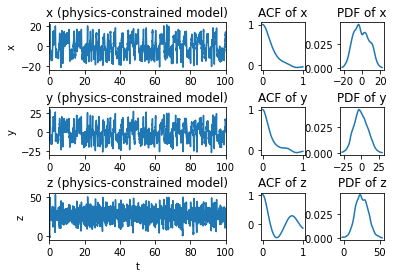

In [33]:
# Surrogate model with Physics Constraints
True_Model_Structure = np.array([[1, 1, 0, 0, 0, 0, 0, 0, 0],
                                 [1, 1, 0, 0, 0, 1, 0, 0, 0],
                                 [0, 0, 1, 1, 0, 0, 0, 0, 0]], dtype=int)
Surro_Model_Structure = np.array([[1, 1, 1, 1, 0, 1, 1, 0, 0],
                                  [1, 1, 1, 1, 0, 1, 1, 0, 0],
                                  [1, 1, 1, 1, 0, 1, 1, 0, 0]], dtype=int)

print('Candidate functions:')
print('x, y, z, xy, yz, zx, x^2, y^2, z^2')
print('Model structure (truth):')
print(True_Model_Structure)
print('Model structure (Physics constrained surrogate model):')
print(Surro_Model_Structure)

# Parameter estimation of the surrogate model
num_theta = 18
num_constraints = 6
H = np.zeros((num_constraints, num_theta))
H[0, [10, 15]] = 1
H[1, [4, 17]] = 1
H[2, [3, 11]] = 1
H[3, 5] = 1
H[4, 9] = 1
H[5, 16] = 1
g = np.zeros((num_constraints,1))

# regime 1
Theta = np.zeros(num_theta)
Sigma = np.zeros((3, 3))

for _ in range(10):
    count = 0
    for j in range(iind_cut1.shape[0]-1):
        for i in range(iind_cut1[j], iind_cut1[j+1]-1):
            M = np.zeros((3, num_theta))
            mj = 0
            for k in range(3):
                M[k, mj]   = All_Candidates1[0, i]
                M[k, mj+1] = All_Candidates1[1, i]
                M[k, mj+2] = All_Candidates1[2, i]
                M[k, mj+3] = All_Candidates1[3, i]
                M[k, mj+4] = All_Candidates1[5, i]
                M[k, mj+5] = All_Candidates1[6, i]
                mj += 6
            M = M * dt
            z = np.array([x_truth1[i + 1], y_truth1[i + 1], z_truth1[i + 1]])
            s = np.array([x_truth1[i], y_truth1[i], z_truth1[i]])
            Sigma += np.outer(z - M @ Theta - s, z - M @ Theta - s)
            count += 1

    Sigma = Sigma / count * np.eye(3)
    invSigma = np.linalg.inv(Sigma)
    D = np.zeros((num_theta, num_theta))
    c = np.zeros((num_theta,1))

    for j in range(iind_cut1.shape[0]-1):
        for i in range(iind_cut1[j], iind_cut1[j+1]-1):
            M = np.zeros((3, num_theta))
            mj = 0
            for k in range(3):
                M[k, mj]   = All_Candidates1[0, i]
                M[k, mj+1] = All_Candidates1[1, i]
                M[k, mj+2] = All_Candidates1[2, i]
                M[k, mj+3] = All_Candidates1[3, i]
                M[k, mj+4] = All_Candidates1[5, i]
                M[k, mj+5] = All_Candidates1[6, i]
                mj += 6
            M = M * dt
            z = np.array([x_truth1[i + 1], y_truth1[i + 1], z_truth1[i + 1]])[:,None]
            s = np.array([x_truth1[i], y_truth1[i], z_truth1[i]])[:,None]
            D += M.T @ invSigma @ M
            c += M.T @ invSigma @ (z - s)

    D = D / count
    c = c / count
    Theta1 = np.linalg.solve(D, c)
    lambda_val = np.linalg.inv(H @ np.linalg.inv(D) @ H.T) @ (H @ np.linalg.inv(D) @ c - g)
    Theta1_Constraint = np.linalg.solve(D, c - H.T @ lambda_val)

Sigma1 = Sigma
print('Theta1_Constraint\n',np.reshape(Theta1_Constraint, (3,6)))
print('Sigma1\n',Sigma1)
print('sigma1\n',(Sigma1/dt)**0.5)

# regime 2
Theta = np.zeros(num_theta)
Sigma = np.zeros((3, 3))

for _ in range(10):
    count = 0
    for j in range(iind_cut2.shape[0]-1):
        for i in range(iind_cut2[j], iind_cut2[j+1]-1):
            M = np.zeros((3, num_theta))
            mj = 0
            for k in range(3):
                M[k, mj]   = All_Candidates2[0, i]
                M[k, mj+1] = All_Candidates2[1, i]
                M[k, mj+2] = All_Candidates2[2, i]
                M[k, mj+3] = All_Candidates2[3, i]
                M[k, mj+4] = All_Candidates2[5, i]
                M[k, mj+5] = All_Candidates2[6, i]
                mj += 6
            M = M * dt
            z = np.array([x_truth2[i + 1], y_truth2[i + 1], z_truth2[i + 1]])
            s = np.array([x_truth2[i], y_truth2[i], z_truth2[i]])
            Sigma += np.outer(z - M @ Theta - s, z - M @ Theta - s)
            count += 1

    Sigma = Sigma / count * np.eye(3)
    invSigma = np.linalg.inv(Sigma)
    D = np.zeros((num_theta, num_theta))
    c = np.zeros((num_theta,1))

    for j in range(iind_cut2.shape[0]-1):
        for i in range(iind_cut2[j], iind_cut2[j+1]-1):
            M = np.zeros((3, num_theta))
            mj = 0
            for k in range(3):
                M[k, mj]   = All_Candidates2[0, i]
                M[k, mj+1] = All_Candidates2[1, i]
                M[k, mj+2] = All_Candidates2[2, i]
                M[k, mj+3] = All_Candidates2[3, i]
                M[k, mj+4] = All_Candidates2[5, i]
                M[k, mj+5] = All_Candidates2[6, i]
                mj += 6
            M = M * dt
            z = np.array([x_truth2[i + 1], y_truth2[i + 1], z_truth2[i + 1]])[:,None]
            s = np.array([x_truth2[i], y_truth2[i], z_truth2[i]])[:,None]
            D += M.T @ invSigma @ M
            c += M.T @ invSigma @ (z - s)

    D = D / count
    c = c / count
    Theta1 = np.linalg.solve(D, c)
    lambda_val = np.linalg.inv(H @ np.linalg.inv(D) @ H.T) @ (H @ np.linalg.inv(D) @ c - g)
    Theta2_Constraint = np.linalg.solve(D, c - H.T @ lambda_val)

Sigma2 = Sigma
print('Theta2_Constraint\n',np.reshape(Theta2_Constraint, (3,6)))
print('Sigma2\n',Sigma2)
print('sigma2\n',(Sigma2/dt)**0.5)

x1 = np.zeros(N)
y1 = np.zeros(N)
z1 = np.zeros(N)
der_x = np.zeros(N)
der_y = np.zeros(N)
der_z = np.zeros(N)
sol = np.squeeze(np.load('nature_run1.npy'))
der = np.squeeze(np.load('derivative.npy'))
lagtime = 32
laginter = 8
sequence_length = int(lagtime/laginter)+1  # length of time sequences
x1[0:lagtime+1] = sol[0,:lagtime+1]
y1[0:lagtime+1] = sol[1,:lagtime+1]
z1[0:lagtime+1] = sol[2,:lagtime+1]
der_x[0:lagtime+1] = der[0,:lagtime+1]
der_y[0:lagtime+1] = der[1,:lagtime+1]
der_z[0:lagtime+1] = der[2,:lagtime+1]

np.random.seed(10)

classify_model = joblib.load("kmeans_model.joblib")
pred_label = np.zeros(N)
pred_label[0:lagtime+1] = label[0:lagtime+1]
for i in range(lagtime+1, N):
    X_features = np.array([])
    for k in range(sequence_length):
        X_features = np.concatenate([X_features, np.array([x1[i-1-lagtime+k*laginter], y1[i-1-lagtime+k*laginter], z1[i-1-lagtime+k*laginter], 
                               der_x[i-1-lagtime+k*laginter], der_y[i-1-lagtime+k*laginter], der_z[i-1-lagtime+k*laginter]])], axis=0)
    if classify_model.predict(X_features[None,:])[0] == 1:
        pred_label[i] = 1
        der_x[i-1] = (Theta1_Constraint[0] * x1[i - 1] + Theta1_Constraint[1] * y1[i - 1] + Theta1_Constraint[2] * z1[i - 1] + Theta1_Constraint[3] * x1[i-1]*y1[i - 1] + Theta1_Constraint[4] * x1[i-1]*z1[i - 1] + Theta1_Constraint[5] * x1[i-1]**2) * dt + np.sqrt(Sigma1[0, 0] / dt) * np.sqrt(dt) * np.random.randn()
        der_y[i-1] = (Theta1_Constraint[6] * x1[i - 1] + Theta1_Constraint[7] * y1[i - 1] + Theta1_Constraint[8] * z1[i - 1] + Theta1_Constraint[9] * x1[i-1]*y1[i - 1] + Theta1_Constraint[10] * x1[i-1]*z1[i - 1] + Theta1_Constraint[11] * x1[i-1]**2) * dt + np.sqrt(Sigma1[1, 1] / dt) * np.sqrt(dt) * np.random.randn()
        der_z[i-1] = (Theta1_Constraint[12] * x1[i - 1] + Theta1_Constraint[13] * y1[i - 1] + Theta1_Constraint[14] * z1[i - 1] + Theta1_Constraint[15] * x1[i-1]*y1[i - 1] + Theta1_Constraint[16] * x1[i-1]*z1[i - 1] + Theta1_Constraint[17] * x1[i-1]**2) * dt + np.sqrt(Sigma1[2, 2] / dt) * np.sqrt(dt) * np.random.randn()
        x1[i] = x1[i - 1] + der_x[i-1]
        y1[i] = y1[i - 1] + der_y[i-1]
        z1[i] = z1[i - 1] + der_z[i-1]
    else:
        der_x[i-1] = (Theta2_Constraint[0] * x1[i - 1] + Theta2_Constraint[1] * y1[i - 1] + Theta2_Constraint[2] * z1[i - 1] + Theta2_Constraint[3] * x1[i-1]*y1[i - 1] + Theta2_Constraint[4] * x1[i-1]*z1[i - 1] + Theta2_Constraint[5] * x1[i-1]**2) * dt + np.sqrt(Sigma2[0, 0] / dt) * np.sqrt(dt) * np.random.randn()
        der_y[i-1] = (Theta2_Constraint[6] * x1[i - 1] + Theta2_Constraint[7] * y1[i - 1] + Theta2_Constraint[8] * z1[i - 1] + Theta2_Constraint[9] * x1[i-1]*y1[i - 1] + Theta2_Constraint[10] * x1[i-1]*z1[i - 1] + Theta2_Constraint[11] * x1[i-1]**2) * dt + np.sqrt(Sigma2[1, 1] / dt) * np.sqrt(dt) * np.random.randn()
        der_z[i-1] = (Theta2_Constraint[12] * x1[i - 1] + Theta2_Constraint[13] * y1[i - 1] + Theta2_Constraint[14] * z1[i - 1] + Theta2_Constraint[15] * x1[i-1]*y1[i - 1] + Theta2_Constraint[16] * x1[i-1]*z1[i - 1] + Theta2_Constraint[17] * x1[i-1]**2) * dt + np.sqrt(Sigma2[2, 2] / dt) * np.sqrt(dt) * np.random.randn()
        x1[i] = x1[i - 1] + der_x[i-1]
        y1[i] = y1[i - 1] + der_y[i-1]
        z1[i] = z1[i - 1] + der_z[i-1]
        
# plot
fig = plt.figure()
widths = [8, 2, 2]
heights = [2, 2, 2]
spec = fig.add_gridspec(ncols=3, nrows=3, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.4, hspace=0.8)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[2, 0])
ax4 = fig.add_subplot(spec[0, 1])
ax5 = fig.add_subplot(spec[1, 1])
ax6 = fig.add_subplot(spec[2, 1])
ax7 = fig.add_subplot(spec[0, 2])
ax8 = fig.add_subplot(spec[1, 2])
ax9 = fig.add_subplot(spec[2, 2])

# Subplot for x_1
sel0 = 0
sel1 = N
ax1.plot(np.arange(0, N * dt, dt), x1)
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_title('x (physics-constrained model)')
ax1.set_ylabel('x')

ax2.plot(np.arange(0, N * dt, dt), y1)
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_title('y (physics-constrained model)')
ax2.set_ylabel('y')

ax3.plot(np.arange(0, N * dt, dt), z1)
ax3.set_xlim(sel0*dt, sel1*dt)
ax3.set_title('z (physics-constrained model)')
ax3.set_ylabel('z')
ax3.set_xlabel('t')

# Subplot for ACF of x_1
ax4.plot(np.arange(0, Lag * dt, dt), stattools.acf(x1, nlags=Lag-1))
ax4.set_title('ACF of x')

ax5.plot(np.arange(0, Lag * dt, dt), stattools.acf(y1, nlags=Lag-1))
ax5.set_title('ACF of y')

ax6.plot(np.arange(0, Lag * dt, dt), stattools.acf(z1, nlags=Lag-1))
ax6.set_title('ACF of z')

# Subplot for PDF of x_1
kde = gaussian_kde(x1)
xx = np.linspace(np.min(x1), np.max(x1), 100)
fi = kde.evaluate(xx)
ax7.plot(xx, fi)
ax7.set_title('PDF of x')

kde = gaussian_kde(y1)
xx = np.linspace(np.min(y1), np.max(y1), 100)
fi = kde.evaluate(xx)
ax8.plot(xx, fi)
ax8.set_title('PDF of y')

kde = gaussian_kde(z1)
xx = np.linspace(np.min(z1), np.max(z1), 100)
fi = kde.evaluate(xx)
ax9.plot(xx, fi)
ax9.set_title('PDF of z')
# plt.savefig('../../fig/RegimePhysConstrModel.png', dpi=150)
plt.show()


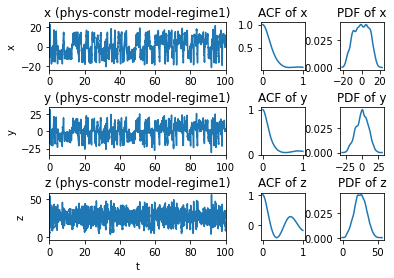

In [34]:
# independent run regime1 model
x1 = np.zeros(N)
y1 = np.zeros(N)
z1 = np.zeros(N)
der_x = np.zeros(N)
der_y = np.zeros(N)
der_z = np.zeros(N)
sol = np.squeeze(np.load('nature_run1.npy'))
der = np.squeeze(np.load('derivative.npy'))
x1[0] = sol[0,0]
y1[0] = sol[1,0]
z1[0] = sol[2,0]

np.random.seed(10)

for i in range(1, N):
    der_x[i-1] = (Theta1_Constraint[0] * x1[i - 1] + Theta1_Constraint[1] * y1[i - 1] + Theta1_Constraint[2] * z1[i - 1] + Theta1_Constraint[3] * x1[i-1]*y1[i - 1] + Theta1_Constraint[4] * x1[i-1]*z1[i - 1] + Theta1_Constraint[5] * x1[i-1]**2) * dt + np.sqrt(Sigma1[0, 0] / dt) * np.sqrt(dt) * np.random.randn()
    der_y[i-1] = (Theta1_Constraint[6] * x1[i - 1] + Theta1_Constraint[7] * y1[i - 1] + Theta1_Constraint[8] * z1[i - 1] + Theta1_Constraint[9] * x1[i-1]*y1[i - 1] + Theta1_Constraint[10] * x1[i-1]*z1[i - 1] + Theta1_Constraint[11] * x1[i-1]**2) * dt + np.sqrt(Sigma1[1, 1] / dt) * np.sqrt(dt) * np.random.randn()
    der_z[i-1] = (Theta1_Constraint[12] * x1[i - 1] + Theta1_Constraint[13] * y1[i - 1] + Theta1_Constraint[14] * z1[i - 1] + Theta1_Constraint[15] * x1[i-1]*y1[i - 1] + Theta1_Constraint[16] * x1[i-1]*z1[i - 1] + Theta1_Constraint[17] * x1[i-1]**2) * dt + np.sqrt(Sigma1[2, 2] / dt) * np.sqrt(dt) * np.random.randn()
    x1[i] = x1[i - 1] + der_x[i-1]
    y1[i] = y1[i - 1] + der_y[i-1]
    z1[i] = z1[i - 1] + der_z[i-1]
    
# plot
fig = plt.figure()
widths = [8, 2, 2]
heights = [2, 2, 2]
spec = fig.add_gridspec(ncols=3, nrows=3, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.4, hspace=0.8)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[2, 0])
ax4 = fig.add_subplot(spec[0, 1])
ax5 = fig.add_subplot(spec[1, 1])
ax6 = fig.add_subplot(spec[2, 1])
ax7 = fig.add_subplot(spec[0, 2])
ax8 = fig.add_subplot(spec[1, 2])
ax9 = fig.add_subplot(spec[2, 2])

# Subplot for x_1
sel0 = 0
sel1 = N
ax1.plot(np.arange(0, N * dt, dt), x1)
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_title('x (phys-constr model-regime1)')
ax1.set_ylabel('x')

ax2.plot(np.arange(0, N * dt, dt), y1)
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_title('y (phys-constr model-regime1)')
ax2.set_ylabel('y')

ax3.plot(np.arange(0, N * dt, dt), z1)
ax3.set_xlim(sel0*dt, sel1*dt)
ax3.set_title('z (phys-constr model-regime1)')
ax3.set_ylabel('z')
ax3.set_xlabel('t')

# Subplot for ACF of x_1
ax4.plot(np.arange(0, Lag * dt, dt), stattools.acf(x1, nlags=Lag-1))
ax4.set_title('ACF of x')

ax5.plot(np.arange(0, Lag * dt, dt), stattools.acf(y1, nlags=Lag-1))
ax5.set_title('ACF of y')

ax6.plot(np.arange(0, Lag * dt, dt), stattools.acf(z1, nlags=Lag-1))
ax6.set_title('ACF of z')

# Subplot for PDF of x_1
kde = gaussian_kde(x1)
xx = np.linspace(np.min(x1), np.max(x1), 100)
fi = kde.evaluate(xx)
ax7.plot(xx, fi)
ax7.set_title('PDF of x')

kde = gaussian_kde(y1)
xx = np.linspace(np.min(y1), np.max(y1), 100)
fi = kde.evaluate(xx)
ax8.plot(xx, fi)
ax8.set_title('PDF of y')

kde = gaussian_kde(z1)
xx = np.linspace(np.min(z1), np.max(z1), 100)
fi = kde.evaluate(xx)
ax9.plot(xx, fi)
ax9.set_title('PDF of z')
# plt.savefig('../../fig/Regime1PhysConstrModel.png', dpi=150)
plt.show()

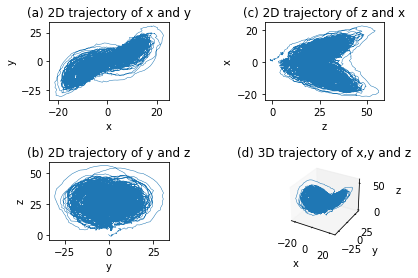

In [40]:
# plot
fig = plt.figure()
widths = [3, 3]
heights = [16, 16]
spec = fig.add_gridspec(ncols=2, nrows=2, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.8, hspace=0.8)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[0, 1])
ax4 = fig.add_subplot(spec[1, 1], projection='3d')

# Subplot for x_1
ax1.plot(x1, y1, lw=0.5)
ax1.set_title('(a) 2D trajectory of x and y')
ax1.set_xlabel('x')
ax1.set_ylabel('y')

ax2.plot(y1, z1, lw=0.5)
ax2.set_title('(b) 2D trajectory of y and z')
ax2.set_xlabel('y')
ax2.set_ylabel('z')

ax3.plot(z1, x1, lw=0.5)
ax3.set_title('(c) 2D trajectory of z and x')
ax3.set_xlabel('z')
ax3.set_ylabel('x')

ax4.plot(x1, y1, z1, lw=0.5)
ax4.set_xlabel("x")
ax4.set_ylabel("y")
ax4.set_zlabel("z")
ax4.set_title('(d) 3D trajectory of x,y and z')
ax4.grid(False)
    
plt.savefig('../../fig/Regime1PhysConstrModel_2dtraj.png', dpi=150)
plt.show()

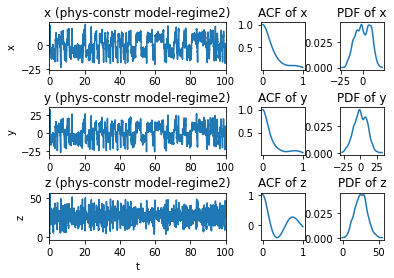

In [41]:
# independent run regime2 model
x1 = np.zeros(N)
y1 = np.zeros(N)
z1 = np.zeros(N)
der_x = np.zeros(N)
der_y = np.zeros(N)
der_z = np.zeros(N)
sol = np.squeeze(np.load('nature_run1.npy'))
der = np.squeeze(np.load('derivative.npy'))
x1[0] = sol[0,0]
y1[0] = sol[1,0]
z1[0] = sol[2,0]

np.random.seed(10)

for i in range(1, N):
    der_x[i-1] = (Theta2_Constraint[0] * x1[i - 1] + Theta2_Constraint[1] * y1[i - 1] + Theta2_Constraint[2] * z1[i - 1] + Theta2_Constraint[3] * x1[i-1]*y1[i - 1] + Theta2_Constraint[4] * x1[i-1]*z1[i - 1] + Theta2_Constraint[5] * x1[i-1]**2) * dt + np.sqrt(Sigma2[0, 0] / dt) * np.sqrt(dt) * np.random.randn()
    der_y[i-1] = (Theta2_Constraint[6] * x1[i - 1] + Theta2_Constraint[7] * y1[i - 1] + Theta2_Constraint[8] * z1[i - 1] + Theta2_Constraint[9] * x1[i-1]*y1[i - 1] + Theta2_Constraint[10] * x1[i-1]*z1[i - 1] + Theta2_Constraint[11] * x1[i-1]**2) * dt + np.sqrt(Sigma2[1, 1] / dt) * np.sqrt(dt) * np.random.randn()
    der_z[i-1] = (Theta2_Constraint[12] * x1[i - 1] + Theta2_Constraint[13] * y1[i - 1] + Theta2_Constraint[14] * z1[i - 1] + Theta2_Constraint[15] * x1[i-1]*y1[i - 1] + Theta2_Constraint[16] * x1[i-1]*z1[i - 1] + Theta2_Constraint[17] * x1[i-1]**2) * dt + np.sqrt(Sigma2[2, 2] / dt) * np.sqrt(dt) * np.random.randn()
    x1[i] = x1[i - 1] + der_x[i-1]
    y1[i] = y1[i - 1] + der_y[i-1]
    z1[i] = z1[i - 1] + der_z[i-1]
    
# plot
fig = plt.figure()
widths = [8, 2, 2]
heights = [2, 2, 2]
spec = fig.add_gridspec(ncols=3, nrows=3, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.4, hspace=0.8)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[2, 0])
ax4 = fig.add_subplot(spec[0, 1])
ax5 = fig.add_subplot(spec[1, 1])
ax6 = fig.add_subplot(spec[2, 1])
ax7 = fig.add_subplot(spec[0, 2])
ax8 = fig.add_subplot(spec[1, 2])
ax9 = fig.add_subplot(spec[2, 2])

# Subplot for x_1
sel0 = 0
sel1 = N
ax1.plot(np.arange(0, N * dt, dt), x1)
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_title('x (phys-constr model-regime2)')
ax1.set_ylabel('x')

ax2.plot(np.arange(0, N * dt, dt), y1)
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_title('y (phys-constr model-regime2)')
ax2.set_ylabel('y')

ax3.plot(np.arange(0, N * dt, dt), z1)
ax3.set_xlim(sel0*dt, sel1*dt)
ax3.set_title('z (phys-constr model-regime2)')
ax3.set_ylabel('z')
ax3.set_xlabel('t')

# Subplot for ACF of x_1
ax4.plot(np.arange(0, Lag * dt, dt), stattools.acf(x1, nlags=Lag-1))
ax4.set_title('ACF of x')

ax5.plot(np.arange(0, Lag * dt, dt), stattools.acf(y1, nlags=Lag-1))
ax5.set_title('ACF of y')

ax6.plot(np.arange(0, Lag * dt, dt), stattools.acf(z1, nlags=Lag-1))
ax6.set_title('ACF of z')

# Subplot for PDF of x_1
kde = gaussian_kde(x1)
xx = np.linspace(np.min(x1), np.max(x1), 100)
fi = kde.evaluate(xx)
ax7.plot(xx, fi)
ax7.set_title('PDF of x')

kde = gaussian_kde(y1)
xx = np.linspace(np.min(y1), np.max(y1), 100)
fi = kde.evaluate(xx)
ax8.plot(xx, fi)
ax8.set_title('PDF of y')

kde = gaussian_kde(z1)
xx = np.linspace(np.min(z1), np.max(z1), 100)
fi = kde.evaluate(xx)
ax9.plot(xx, fi)
ax9.set_title('PDF of z')
# plt.savefig('../../fig/Regime2PhysConstrModel.png', dpi=150)
plt.show()

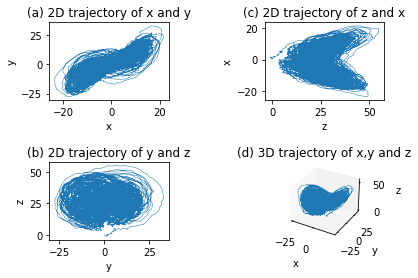

In [42]:
# plot
fig = plt.figure()
widths = [3, 3]
heights = [16, 16]
spec = fig.add_gridspec(ncols=2, nrows=2, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.8, hspace=0.8)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[0, 1])
ax4 = fig.add_subplot(spec[1, 1], projection='3d')

# Subplot for x_1
ax1.plot(x1, y1, lw=0.5)
ax1.set_title('(a) 2D trajectory of x and y')
ax1.set_xlabel('x')
ax1.set_ylabel('y')

ax2.plot(y1, z1, lw=0.5)
ax2.set_title('(b) 2D trajectory of y and z')
ax2.set_xlabel('y')
ax2.set_ylabel('z')

ax3.plot(z1, x1, lw=0.5)
ax3.set_title('(c) 2D trajectory of z and x')
ax3.set_xlabel('z')
ax3.set_ylabel('x')

ax4.plot(x1, y1, z1, lw=0.5)
ax4.set_xlabel("x")
ax4.set_ylabel("y")
ax4.set_zlabel("z")
ax4.set_title('(d) 3D trajectory of x,y and z')
ax4.grid(False)
    
plt.savefig('../../fig/Regime2PhysConstrModel_traj.png', dpi=150)
plt.show()

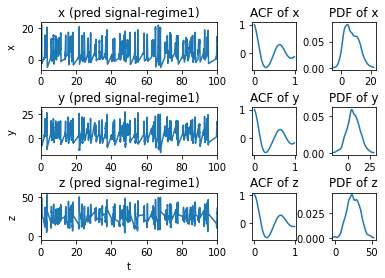

In [26]:
# predict plot regime1
boolpredlab = pred_label==1
xpred1 = x1[boolpredlab]
ypred1 = y1[boolpredlab]
zpred1 = z1[boolpredlab]
xpred2 = x1[~boolpredlab]
ypred2 = y1[~boolpredlab]
zpred2 = z1[~boolpredlab]
indt1 = np.where(pred_label==1)[0]
indt2 = np.where(pred_label==0)[0]

# plot
fig = plt.figure()
widths = [8, 2, 2]
heights = [2, 2, 2]
spec = fig.add_gridspec(ncols=3, nrows=3, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.4, hspace=0.8)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[2, 0])
ax4 = fig.add_subplot(spec[0, 1])
ax5 = fig.add_subplot(spec[1, 1])
ax6 = fig.add_subplot(spec[2, 1])
ax7 = fig.add_subplot(spec[0, 2])
ax8 = fig.add_subplot(spec[1, 2])
ax9 = fig.add_subplot(spec[2, 2])

# Subplot for xpred
sel0 = 0
sel1 = N
ax1.plot(indt1.astype(float)*dt, xpred1)
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_title('x (pred signal-regime1)')
ax1.set_ylabel('x')

ax2.plot(indt1.astype(float)*dt, ypred1)
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_title('y (pred signal-regime1)')
ax2.set_ylabel('y')

ax3.plot(indt1.astype(float)*dt, zpred1)
ax3.set_xlim(sel0*dt, sel1*dt)
ax3.set_title('z (pred signal-regime1)')
ax3.set_ylabel('z')
ax3.set_xlabel('t')

# Remove last point from candidates
indt1 = indt1[:-1]
indt2 = indt2[:-1]

ind_cut1 = [indt1[0]]
for i in range(indt1.shape[0]-1):
    if (indt1[i+1] - indt1[i]) > 1:
        ind_cut1.append(indt1[i+1])
# Use numpy.in1d to create a boolean mask for elements in arr that are in elements_to_find
mask = np.in1d(indt1, ind_cut1)
# Use numpy.where to get the indices where the mask is True
iind_cut1 = np.where(mask)[0]
iind_cut1 = np.append(iind_cut1, indt1.shape[0])

ind_cut2 = [indt2[0]]
for i in range(indt2.shape[0]-1):
    if (indt2[i+1] - indt2[i]) > 1:
        ind_cut2.append(indt2[i+1])
# Use numpy.in1d to create a boolean mask for elements in arr that are in elements_to_find
mask = np.in1d(indt2, ind_cut2)
# Use numpy.where to get the indices where the mask is True
iind_cut2 = np.where(mask)[0]
iind_cut2 = np.append(iind_cut2, indt2.shape[0])

Lag = 200

# Subplot for ACF of xpred
# calculate mean ACF
indlag = []
acfx = 0
acfy = 0
acfz = 0
nacf = 0
for i in range(1, iind_cut1.shape[0]):
    if (iind_cut1[i] - iind_cut1[i-1]) > Lag:
        indlag.append(iind_cut1[i-1])
        acfx += stattools.acf(xpred1[iind_cut1[i-1]:iind_cut1[i]], nlags=Lag-1)
        acfy += stattools.acf(ypred1[iind_cut1[i-1]:iind_cut1[i]], nlags=Lag-1)
        acfz += stattools.acf(zpred1[iind_cut1[i-1]:iind_cut1[i]], nlags=Lag-1)
        nacf += 1
acfx = acfx / nacf
acfy = acfy / nacf
acfz = acfz / nacf

ax4.plot(np.arange(0, Lag * dt, dt), acfx)
ax4.set_title('ACF of x')

ax5.plot(np.arange(0, Lag * dt, dt), acfy)
ax5.set_title('ACF of y')

ax6.plot(np.arange(0, Lag * dt, dt), acfz)
ax6.set_title('ACF of z')

# Subplot for PDF of xpred
kde = gaussian_kde(xpred1)
xx = np.linspace(np.min(xpred1), np.max(xpred1), 100)
fi = kde.evaluate(xx)
ax7.plot(xx, fi)
ax7.set_title('PDF of x')

kde = gaussian_kde(ypred1)
xx = np.linspace(np.min(ypred1), np.max(ypred1), 100)
fi = kde.evaluate(xx)
ax8.plot(xx, fi)
ax8.set_title('PDF of y')

kde = gaussian_kde(zpred1)
xx = np.linspace(np.min(zpred1), np.max(zpred1), 100)
fi = kde.evaluate(xx)
ax9.plot(xx, fi)
ax9.set_title('PDF of z')
plt.savefig('../../fig/pred_regm1.png', dpi=150)
plt.show()

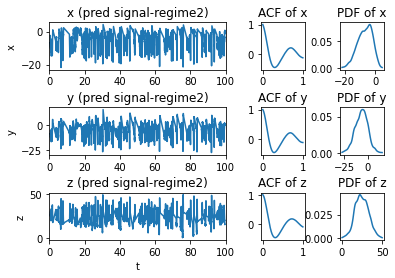

In [27]:
# predict plot regime2
indt2 = np.where(pred_label==0)[0]
# plot
fig = plt.figure()
widths = [8, 2, 2]
heights = [2, 2, 2]
spec = fig.add_gridspec(ncols=3, nrows=3, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.4, hspace=0.8)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[2, 0])
ax4 = fig.add_subplot(spec[0, 1])
ax5 = fig.add_subplot(spec[1, 1])
ax6 = fig.add_subplot(spec[2, 1])
ax7 = fig.add_subplot(spec[0, 2])
ax8 = fig.add_subplot(spec[1, 2])
ax9 = fig.add_subplot(spec[2, 2])

# Subplot for xpred
sel0 = 0
sel1 = N
ax1.plot(indt2.astype(float)*dt, xpred2)
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_title('x (pred signal-regime2)')
ax1.set_ylabel('x')

ax2.plot(indt2.astype(float)*dt, ypred2)
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_title('y (pred signal-regime2)')
ax2.set_ylabel('y')

ax3.plot(indt2.astype(float)*dt, zpred2)
ax3.set_xlim(sel0*dt, sel1*dt)
ax3.set_title('z (pred signal-regime2)')
ax3.set_ylabel('z')
ax3.set_xlabel('t')

Lag = 200

# Subplot for ACF of xpred
# calculate mean ACF
indlag = []
acfx = 0
acfy = 0
acfz = 0
nacf = 0
for i in range(1, iind_cut2.shape[0]):
    if (iind_cut2[i] - iind_cut2[i-1]) > Lag:
        indlag.append(iind_cut2[i-1])
        acfx += stattools.acf(xpred2[iind_cut2[i-1]:iind_cut2[i]], nlags=Lag-1)
        acfy += stattools.acf(ypred2[iind_cut2[i-1]:iind_cut2[i]], nlags=Lag-1)
        acfz += stattools.acf(zpred2[iind_cut2[i-1]:iind_cut2[i]], nlags=Lag-1)
        nacf += 1
acfx = acfx / nacf
acfy = acfy / nacf
acfz = acfz / nacf

ax4.plot(np.arange(0, Lag * dt, dt), acfx)
ax4.set_title('ACF of x')

ax5.plot(np.arange(0, Lag * dt, dt), acfy)
ax5.set_title('ACF of y')

ax6.plot(np.arange(0, Lag * dt, dt), acfz)
ax6.set_title('ACF of z')

# Subplot for PDF of xpred
kde = gaussian_kde(xpred2)
xx = np.linspace(np.min(xpred2), np.max(xpred2), 100)
fi = kde.evaluate(xx)
ax7.plot(xx, fi)
ax7.set_title('PDF of x')

kde = gaussian_kde(ypred2)
xx = np.linspace(np.min(ypred2), np.max(ypred2), 100)
fi = kde.evaluate(xx)
ax8.plot(xx, fi)
ax8.set_title('PDF of y')

kde = gaussian_kde(zpred2)
xx = np.linspace(np.min(zpred2), np.max(zpred2), 100)
fi = kde.evaluate(xx)
ax9.plot(xx, fi)
ax9.set_title('PDF of z')
plt.savefig('../../fig/pred_regm2.png', dpi=150)
plt.show()

In [77]:
# Surrogate model with Model Identification
from scipy.linalg import det

True_Model_Structure = np.array([[1, 1, 0, 0, 0, 0],
                                 [1, 1, 0, 0, 1, 0],
                                 [0, 0, 1, 1, 0, 0]], dtype=int)

# Parameters
threshold = 0.0005 # threshold of causation entropy
L = 6

# load label data
label = np.load('SeqKmeans_label_2center_naturerun.npy')
print(label.shape)

# Truth
x_truth = truth[0, 0, lagtime:]
y_truth = truth[1, 0, lagtime:]
z_truth = truth[2, 0, lagtime:]

# Define candidates and true model structure
All_Candidates = np.vstack((x_truth, y_truth, z_truth, x_truth * y_truth, z_truth * x_truth, x_truth**2))

# Partition data into 8 regimes
ncenters = 8
x_truths = []
y_truths = []
z_truths = []
All_Candi_list = []
indts = []
iind_cuts = []

for nc in range(ncenters):
    bool_label = label == nc
    x_truths.append(x_truth[bool_label])
    y_truths.append(y_truth[bool_label])
    z_truths.append(z_truth[bool_label])
    All_Candi_list.append(All_Candidates[:,bool_label][:, :-1])   # Remove last point from candidates
    indts.append(np.where(bool_label)[0][:-1]) 

    indt = indts[nc]
    ind_cut = [indt[0]]
    for i in range(indt.shape[0]-1):
        if (indt[i+1] - indt[i]) > 1:
            ind_cut.append(indt[i+1])
            
    # Use numpy.in1d to create a boolean mask for elements in arr that are in elements_to_find
    mask = np.in1d(indt, ind_cut)
    # Use numpy.where to get the indices where the mask is True
    iind_cut = np.where(mask)[0]
    iind_cut = np.append(iind_cut, indt.shape[0])
    iind_cuts.append(iind_cut)

# Compute time derivatives
deriv = np.load('derivative.npy')
deriv = np.roll(deriv[:,0,lagtime:], -1, axis=1) # shift derivatives by -1, since deriv[i] corresponds to sol[i+1]
deriv1 = deriv[:,bool_label]
deriv2 = deriv[:,~bool_label][:, :-1] # remove the last element
x_derivative1 = deriv1[0,:] / dt
y_derivative1 = deriv1[1,:] / dt
z_derivative1 = deriv1[2,:] / dt
x_derivative2 = deriv2[0,:] / dt
y_derivative2 = deriv2[1,:] / dt
z_derivative2 = deriv2[2,:] / dt

print(deriv2.shape, All_Candidates2.shape)
print('Candidate functions:')
print('x, y, z, xy, zx, x^2')

# regime1
# Calculate causation entropy matrix (CEM) based on the Gaussian approximation
CEM = np.zeros((3, L))
for k in range(3):
    if k == 0:
        All_Variables1 = np.vstack((All_Candidates1, x_derivative1))
    elif k == 1:
        All_Variables1 = np.vstack((All_Candidates1, y_derivative1))
    elif k == 2:
        All_Variables1 = np.vstack((All_Candidates1, z_derivative1))
    
    All_Cov = np.cov(All_Variables1)
    
    for i in range(L):
        RXY = np.delete(np.delete(All_Cov, i, axis=0), i, axis=1)
        RY = np.delete(np.delete(All_Cov, [i, L], axis=0), [i, L], axis=1)
        RXYZ = All_Cov
        RYZ = All_Cov[:L, :L]

        CEM[k, i] = 0.5 * (np.log(det(RXY)) - np.log(det(RY)) - np.log(det(RXYZ)) + np.log(det(RYZ)))
        
CEM_Original1 = CEM
CEM_indicator1 = (CEM_Original1 > threshold).astype(int)

print('Regime1')
print('Model structure (truth):')
print(True_Model_Structure)
print('Model structure (identified model):')
print(CEM_indicator1)
print('CEM_Original',CEM_Original1)

# regime2
# Calculate causation entropy matrix (CEM) based on the Gaussian approximation
CEM = np.zeros((3, L))
for k in range(3):
    if k == 0:
        All_Variables2 = np.vstack((All_Candidates2, x_derivative2))
    elif k == 1:
        All_Variables2 = np.vstack((All_Candidates2, y_derivative2))
    elif k == 2:
        All_Variables2 = np.vstack((All_Candidates2, z_derivative2))
    
    All_Cov = np.cov(All_Variables2)
    
    for i in range(L):
        RXY = np.delete(np.delete(All_Cov, i, axis=0), i, axis=1)
        RY = np.delete(np.delete(All_Cov, [i, L], axis=0), [i, L], axis=1)
        RXYZ = All_Cov
        RYZ = All_Cov[:L, :L]

        CEM[k, i] = 0.5 * (np.log(det(RXY)) - np.log(det(RY)) - np.log(det(RXYZ)) + np.log(det(RYZ)))
        
CEM_Original2 = CEM
CEM_indicator2 = (CEM_Original2 > threshold).astype(int)

print('Regime2')
print('Model structure (truth):')
print(True_Model_Structure)
print('Model structure (identified model):')
print(CEM_indicator2)
print('CEM_Original',CEM_Original2)

(19969,)
(3, 10850) (6, 10850)
Candidate functions:
x, y, z, xy, zx, x^2
Regime1
Model structure (truth):
[[1 1 0 0 0 0]
 [1 1 0 0 1 0]
 [0 0 1 1 0 0]]
Model structure (identified model):
[[1 1 0 0 0 0]
 [1 0 0 0 1 0]
 [0 0 1 1 0 0]]
CEM_Original [[8.59500712e-03 2.97707428e-02 1.72950967e-04 1.45444435e-04
  1.71152312e-04 9.72502638e-05]
 [7.20029158e-02 1.12180916e-05 4.51622802e-05 1.49782287e-04
  3.65624441e-02 7.90274949e-05]
 [1.46617566e-06 2.06040822e-05 5.20363221e-03 1.88594835e-02
  6.69968230e-05 7.59944119e-05]]
Regime2
Model structure (truth):
[[1 1 0 0 0 0]
 [1 1 0 0 1 0]
 [0 0 1 1 0 0]]
Model structure (identified model):
[[1 1 0 0 0 0]
 [1 0 0 0 1 0]
 [0 0 1 1 0 0]]
CEM_Original [[9.63845745e-03 2.80292955e-02 7.22998591e-05 3.12874619e-05
  5.08765685e-05 1.34054593e-05]
 [7.31664371e-02 1.28838762e-04 1.28950849e-04 3.47530757e-06
  3.75602202e-02 5.02263950e-06]
 [4.61855867e-05 1.34419258e-04 8.67452966e-03 2.57882961e-02
  1.67129984e-05 5.80340933e-05]]


(19969,)
Theta1_Constraint
 [[-10.04351322  10.11608564]
 [ 26.6972805   -0.98419137]
 [ -2.6084081    0.98419137]]
Sigma1
 [[0.19265699 0.         0.        ]
 [0.         0.27425121 0.        ]
 [0.         0.         0.31792722]]
sigma1
 [[6.20736641 0.         0.        ]
 [0.         7.40609498 0.        ]
 [0.         0.         7.97404816]]
Theta2_Constraint
 [[-9.88579857 10.08845663]
 [26.52817071 -0.98608741]
 [-2.66182905  0.98608741]]
Sigma2
 [[ 0.18299223  0.         -0.        ]
 [ 0.          0.25275461 -0.        ]
 [-0.         -0.          0.29440982]]
sigma2
 [[ 6.04966488  0.         -0.        ]
 [ 0.          7.10991713 -0.        ]
 [-0.         -0.          7.67345846]]


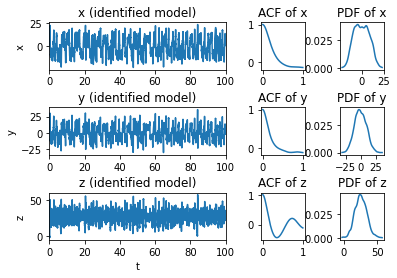

In [89]:
# CEM with Physics Constraints
# load label data
label = np.load('SeqKmeans_label_2center_naturerun.npy')
print(label.shape)

# Truth
x_truth = truth[0, 0, lagtime:]
y_truth = truth[1, 0, lagtime:]
z_truth = truth[2, 0, lagtime:]

# Define candidates and true model structure
All_Candidates = np.vstack((x_truth, y_truth, z_truth, x_truth * y_truth, z_truth * x_truth, x_truth**2))

# Partition data into 2 regimes
bool_label = label == 1
x_truth1 = x_truth[bool_label]
x_truth2 = x_truth[~bool_label]
y_truth1 = y_truth[bool_label]
y_truth2 = y_truth[~bool_label]
z_truth1 = z_truth[bool_label]
z_truth2 = z_truth[~bool_label]
All_Candidates1 = All_Candidates[:,bool_label]
All_Candidates2 = All_Candidates[:,~bool_label]
indt1 = np.where(label==1)[0]
indt2 = np.where(label==0)[0]

# Remove last point from candidates
All_Candidates1 = All_Candidates1[:, :-1]
All_Candidates2 = All_Candidates2[:, :-1]
indt1 = indt1[:-1]
indt2 = indt2[:-1]

ind_cut1 = [indt1[0]]
for i in range(indt1.shape[0]-1):
    if (indt1[i+1] - indt1[i]) > 1:
        ind_cut1.append(indt1[i+1])
# Use numpy.in1d to create a boolean mask for elements in arr that are in elements_to_find
mask = np.in1d(indt1, ind_cut1)
# Use numpy.where to get the indices where the mask is True
iind_cut1 = np.where(mask)[0]
iind_cut1 = np.append(iind_cut1, indt1.shape[0])

ind_cut2 = [indt2[0]]
for i in range(indt2.shape[0]-1):
    if (indt2[i+1] - indt2[i]) > 1:
        ind_cut2.append(indt2[i+1])
# Use numpy.in1d to create a boolean mask for elements in arr that are in elements_to_find
mask = np.in1d(indt2, ind_cut2)
# Use numpy.where to get the indices where the mask is True
iind_cut2 = np.where(mask)[0]
iind_cut2 = np.append(iind_cut2, indt2.shape[0])


# Parameter estimation of the surrogate model
num_theta = 6
num_constraints = 1
H = np.zeros((num_constraints, num_theta))
H[0, [3,5]] = 1
g = np.zeros((num_constraints,1))

# regime 1
Theta = np.zeros(num_theta)
Sigma = np.zeros((3, 3))

for _ in range(10):
    count = 0
    for j in range(iind_cut1.shape[0]-1):
        for i in range(iind_cut1[j], iind_cut1[j+1]-1):
            M = np.zeros((3, num_theta))

            M[0, 0] = All_Candidates1[0, i]
            M[0, 1] = All_Candidates1[1, i]
            M[1, 2] = All_Candidates1[0, i]
            M[1, 3] = All_Candidates1[4, i]
            M[2, 4] = All_Candidates1[2, i]
            M[2, 5] = All_Candidates1[3, i]
 
            M = M * dt
            z = np.array([x_truth1[i + 1], y_truth1[i + 1], z_truth1[i + 1]])
            s = np.array([x_truth1[i], y_truth1[i], z_truth1[i]])
            Sigma += np.outer(z - M @ Theta - s, z - M @ Theta - s)
            count += 1

    Sigma = Sigma / count * np.eye(3)
    invSigma = np.linalg.inv(Sigma)
    D = np.zeros((num_theta, num_theta))
    c = np.zeros((num_theta,1))

    for j in range(iind_cut1.shape[0]-1):
        for i in range(iind_cut1[j], iind_cut1[j+1]-1):
            M = np.zeros((3, num_theta))
                        
            M[0, 0] = All_Candidates1[0, i]
            M[0, 1] = All_Candidates1[1, i]
            M[1, 2] = All_Candidates1[0, i]
            M[1, 3] = All_Candidates1[4, i]
            M[2, 4] = All_Candidates1[2, i]
            M[2, 5] = All_Candidates1[3, i]
 
            M = M * dt
            z = np.array([x_truth1[i + 1], y_truth1[i + 1], z_truth1[i + 1]])[:,None]
            s = np.array([x_truth1[i], y_truth1[i], z_truth1[i]])[:,None]
            D += M.T @ invSigma @ M
            c += M.T @ invSigma @ (z - s)

    D = D / count
    c = c / count
    Theta1 = np.linalg.solve(D, c)
    lambda_val = np.linalg.inv(H @ np.linalg.inv(D) @ H.T) @ (H @ np.linalg.inv(D) @ c - g)
    Theta1_Constraint = np.linalg.solve(D, c - H.T @ lambda_val)

Sigma1 = Sigma
print('Theta1_Constraint\n',np.reshape(Theta1_Constraint, (3,int(num_theta/3))))
print('Sigma1\n',Sigma1)
print('sigma1\n',(Sigma1/dt)**0.5)

# regime 2
Theta = np.zeros(num_theta)
Sigma = np.zeros((3, 3))

for _ in range(10):
    count = 0
    for j in range(iind_cut2.shape[0]-1):
        for i in range(iind_cut2[j], iind_cut2[j+1]-1):
            M = np.zeros((3, num_theta))
                        
            M[0, 0] = All_Candidates2[0, i]
            M[0, 1] = All_Candidates2[1, i]
            M[1, 2] = All_Candidates2[0, i]
            M[1, 3] = All_Candidates2[4, i]
            M[2, 4] = All_Candidates2[2, i]
            M[2, 5] = All_Candidates2[3, i]
            
            M = M * dt
            z = np.array([x_truth2[i + 1], y_truth2[i + 1], z_truth2[i + 1]])
            s = np.array([x_truth2[i], y_truth2[i], z_truth2[i]])
            Sigma += np.outer(z - M @ Theta - s, z - M @ Theta - s)
            count += 1

    Sigma = Sigma / count * np.eye(3)
    invSigma = np.linalg.inv(Sigma)
    D = np.zeros((num_theta, num_theta))
    c = np.zeros((num_theta,1))

    for j in range(iind_cut2.shape[0]-1):
        for i in range(iind_cut2[j], iind_cut2[j+1]-1):
            M = np.zeros((3, num_theta))
            mj = 0
                        
            M[0, 0] = All_Candidates2[0, i]
            M[0, 1] = All_Candidates2[1, i]
            M[1, 2] = All_Candidates2[0, i]
            M[1, 3] = All_Candidates2[4, i]
            M[2, 4] = All_Candidates2[2, i]
            M[2, 5] = All_Candidates2[3, i]
            
            M = M * dt
            z = np.array([x_truth2[i + 1], y_truth2[i + 1], z_truth2[i + 1]])[:,None]
            s = np.array([x_truth2[i], y_truth2[i], z_truth2[i]])[:,None]
            D += M.T @ invSigma @ M
            c += M.T @ invSigma @ (z - s)

    D = D / count
    c = c / count
    Theta1 = np.linalg.solve(D, c)
    lambda_val = np.linalg.inv(H @ np.linalg.inv(D) @ H.T) @ (H @ np.linalg.inv(D) @ c - g)
    Theta2_Constraint = np.linalg.solve(D, c - H.T @ lambda_val)

Sigma2 = Sigma
print('Theta2_Constraint\n',np.reshape(Theta2_Constraint, (3,int(num_theta/3))))
print('Sigma2\n',Sigma2)
print('sigma2\n',(Sigma2/dt)**0.5)

x1 = np.zeros(N)
y1 = np.zeros(N)
z1 = np.zeros(N)
der_x = np.zeros(N)
der_y = np.zeros(N)
der_z = np.zeros(N)
sol = np.squeeze(np.load('nature_run1.npy'))
der = np.squeeze(np.load('derivative.npy'))
lagtime = 32
laginter = 8
sequence_length = int(lagtime/laginter)+1  # length of time sequences
x1[0:lagtime+1] = sol[0,:lagtime+1]
y1[0:lagtime+1] = sol[1,:lagtime+1]
z1[0:lagtime+1] = sol[2,:lagtime+1]
der_x[0:lagtime+1] = der[0,:lagtime+1]
der_y[0:lagtime+1] = der[1,:lagtime+1]
der_z[0:lagtime+1] = der[2,:lagtime+1]

np.random.seed(10)

classify_model = joblib.load("kmeans_model.joblib")
pred_label = np.zeros(N)
pred_label[0:lagtime+1] = label[0:lagtime+1]
for i in range(lagtime+1, N):
    X_features = np.array([])
    for k in range(sequence_length):
        X_features = np.concatenate([X_features, np.array([x1[i-1-lagtime+k*laginter], y1[i-1-lagtime+k*laginter], z1[i-1-lagtime+k*laginter], 
                               der_x[i-1-lagtime+k*laginter], der_y[i-1-lagtime+k*laginter], der_z[i-1-lagtime+k*laginter]])], axis=0)
    if classify_model.predict(X_features[None,:])[0] == 1:
        pred_label[i] = 1
        der_x[i-1] = (Theta1_Constraint[0] * x1[i - 1] + Theta1_Constraint[1] * y1[i - 1]) * dt + np.sqrt(Sigma1[0, 0] / dt) * np.sqrt(dt) * np.random.randn()
        der_y[i-1] = (Theta1_Constraint[2] * x1[i - 1] + Theta1_Constraint[3] * x1[i - 1]*z1[i - 1]) * dt + np.sqrt(Sigma1[1, 1] / dt) * np.sqrt(dt) * np.random.randn()
        der_z[i-1] = (Theta1_Constraint[4] * z1[i - 1] + Theta1_Constraint[5] * x1[i - 1]*y1[i - 1]) * dt + np.sqrt(Sigma1[2, 2] / dt) * np.sqrt(dt) * np.random.randn()
        x1[i] = x1[i - 1] + der_x[i-1]
        y1[i] = y1[i - 1] + der_y[i-1]
        z1[i] = z1[i - 1] + der_z[i-1]
    else:
        der_x[i-1] = (Theta2_Constraint[0] * x1[i - 1] + Theta2_Constraint[1] * y1[i - 1]) * dt + np.sqrt(Sigma1[0, 0] / dt) * np.sqrt(dt) * np.random.randn()
        der_y[i-1] = (Theta2_Constraint[2] * x1[i - 1] + Theta2_Constraint[3] * x1[i - 1]*z1[i - 1]) * dt + np.sqrt(Sigma1[1, 1] / dt) * np.sqrt(dt) * np.random.randn()
        der_z[i-1] = (Theta2_Constraint[4] * z1[i - 1] + Theta2_Constraint[5] * x1[i - 1]*y1[i - 1]) * dt + np.sqrt(Sigma1[2, 2] / dt) * np.sqrt(dt) * np.random.randn()
        x1[i] = x1[i - 1] + der_x[i-1]
        y1[i] = y1[i - 1] + der_y[i-1]
        z1[i] = z1[i - 1] + der_z[i-1]
        
# plot
fig = plt.figure()
widths = [8, 2, 2]
heights = [2, 2, 2]
spec = fig.add_gridspec(ncols=3, nrows=3, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.4, hspace=0.8)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[2, 0])
ax4 = fig.add_subplot(spec[0, 1])
ax5 = fig.add_subplot(spec[1, 1])
ax6 = fig.add_subplot(spec[2, 1])
ax7 = fig.add_subplot(spec[0, 2])
ax8 = fig.add_subplot(spec[1, 2])
ax9 = fig.add_subplot(spec[2, 2])

# Subplot for x_1
sel0 = 0
sel1 = N
ax1.plot(np.arange(0, N * dt, dt), x1)
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_title('x (identified model)')
ax1.set_ylabel('x')

ax2.plot(np.arange(0, N * dt, dt), y1)
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_title('y (identified model)')
ax2.set_ylabel('y')

ax3.plot(np.arange(0, N * dt, dt), z1)
ax3.set_xlim(sel0*dt, sel1*dt)
ax3.set_title('z (identified model)')
ax3.set_ylabel('z')
ax3.set_xlabel('t')

# Subplot for ACF of x_1
ax4.plot(np.arange(0, Lag * dt, dt), stattools.acf(x1, nlags=Lag-1))
ax4.set_title('ACF of x')

ax5.plot(np.arange(0, Lag * dt, dt), stattools.acf(y1, nlags=Lag-1))
ax5.set_title('ACF of y')

ax6.plot(np.arange(0, Lag * dt, dt), stattools.acf(z1, nlags=Lag-1))
ax6.set_title('ACF of z')

# Subplot for PDF of x_1
kde = gaussian_kde(x1)
xx = np.linspace(np.min(x1), np.max(x1), 100)
fi = kde.evaluate(xx)
ax7.plot(xx, fi)
ax7.set_title('PDF of x')

kde = gaussian_kde(y1)
xx = np.linspace(np.min(y1), np.max(y1), 100)
fi = kde.evaluate(xx)
ax8.plot(xx, fi)
ax8.set_title('PDF of y')

kde = gaussian_kde(z1)
xx = np.linspace(np.min(z1), np.max(z1), 100)
fi = kde.evaluate(xx)
ax9.plot(xx, fi)
ax9.set_title('PDF of z')
# plt.savefig('../../fig/RegimeCEM_Phy.png', dpi=150)
plt.show()


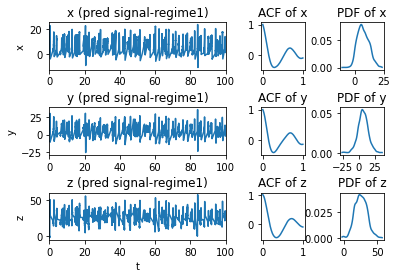

In [90]:
# prediction regime1
boolpredlab = pred_label==1
xpred1 = x1[boolpredlab]
ypred1 = y1[boolpredlab]
zpred1 = z1[boolpredlab]
xpred2 = x1[~boolpredlab]
ypred2 = y1[~boolpredlab]
zpred2 = z1[~boolpredlab]
indt1 = np.where(pred_label==1)[0]
indt2 = np.where(pred_label==0)[0]

# plot
fig = plt.figure()
widths = [8, 2, 2]
heights = [2, 2, 2]
spec = fig.add_gridspec(ncols=3, nrows=3, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.4, hspace=0.8)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[2, 0])
ax4 = fig.add_subplot(spec[0, 1])
ax5 = fig.add_subplot(spec[1, 1])
ax6 = fig.add_subplot(spec[2, 1])
ax7 = fig.add_subplot(spec[0, 2])
ax8 = fig.add_subplot(spec[1, 2])
ax9 = fig.add_subplot(spec[2, 2])

# Subplot for xpred
sel0 = 0
sel1 = N
ax1.plot(indt1.astype(float)*dt, xpred1)
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_title('x (pred signal-regime1)')
ax1.set_ylabel('x')

ax2.plot(indt1.astype(float)*dt, ypred1)
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_title('y (pred signal-regime1)')
ax2.set_ylabel('y')

ax3.plot(indt1.astype(float)*dt, zpred1)
ax3.set_xlim(sel0*dt, sel1*dt)
ax3.set_title('z (pred signal-regime1)')
ax3.set_ylabel('z')
ax3.set_xlabel('t')

# Remove last point from candidates
indt1 = indt1[:-1]
indt2 = indt2[:-1]

ind_cut1 = [indt1[0]]
for i in range(indt1.shape[0]-1):
    if (indt1[i+1] - indt1[i]) > 1:
        ind_cut1.append(indt1[i+1])
# Use numpy.in1d to create a boolean mask for elements in arr that are in elements_to_find
mask = np.in1d(indt1, ind_cut1)
# Use numpy.where to get the indices where the mask is True
iind_cut1 = np.where(mask)[0]
iind_cut1 = np.append(iind_cut1, indt1.shape[0])

ind_cut2 = [indt2[0]]
for i in range(indt2.shape[0]-1):
    if (indt2[i+1] - indt2[i]) > 1:
        ind_cut2.append(indt2[i+1])
# Use numpy.in1d to create a boolean mask for elements in arr that are in elements_to_find
mask = np.in1d(indt2, ind_cut2)
# Use numpy.where to get the indices where the mask is True
iind_cut2 = np.where(mask)[0]
iind_cut2 = np.append(iind_cut2, indt2.shape[0])

Lag = 200

# Subplot for ACF of xpred
# calculate mean ACF
indlag = []
acfx = 0
acfy = 0
acfz = 0
nacf = 0
for i in range(1, iind_cut1.shape[0]):
    if (iind_cut1[i] - iind_cut1[i-1]) > Lag:
        indlag.append(iind_cut1[i-1])
        acfx += stattools.acf(xpred1[iind_cut1[i-1]:iind_cut1[i]], nlags=Lag-1)
        acfy += stattools.acf(ypred1[iind_cut1[i-1]:iind_cut1[i]], nlags=Lag-1)
        acfz += stattools.acf(zpred1[iind_cut1[i-1]:iind_cut1[i]], nlags=Lag-1)
        nacf += 1
acfx = acfx / nacf
acfy = acfy / nacf
acfz = acfz / nacf

ax4.plot(np.arange(0, Lag * dt, dt), acfx)
ax4.set_title('ACF of x')

ax5.plot(np.arange(0, Lag * dt, dt), acfy)
ax5.set_title('ACF of y')

ax6.plot(np.arange(0, Lag * dt, dt), acfz)
ax6.set_title('ACF of z')

# Subplot for PDF of xpred
kde = gaussian_kde(xpred1)
xx = np.linspace(np.min(xpred1), np.max(xpred1), 100)
fi = kde.evaluate(xx)
ax7.plot(xx, fi)
ax7.set_title('PDF of x')

kde = gaussian_kde(ypred1)
xx = np.linspace(np.min(ypred1), np.max(ypred1), 100)
fi = kde.evaluate(xx)
ax8.plot(xx, fi)
ax8.set_title('PDF of y')

kde = gaussian_kde(zpred1)
xx = np.linspace(np.min(zpred1), np.max(zpred1), 100)
fi = kde.evaluate(xx)
ax9.plot(xx, fi)
ax9.set_title('PDF of z')
plt.savefig('../../fig/pred_regm1_CEMPhy.png', dpi=150)
plt.show()

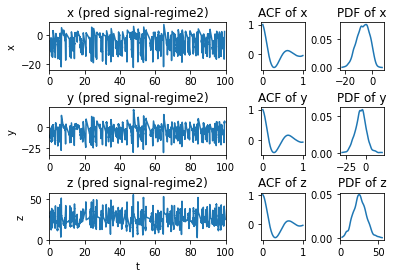

In [91]:
# prediction regime2
indt2 = np.where(pred_label==0)[0]
# plot
fig = plt.figure()
widths = [8, 2, 2]
heights = [2, 2, 2]
spec = fig.add_gridspec(ncols=3, nrows=3, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.4, hspace=0.8)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[2, 0])
ax4 = fig.add_subplot(spec[0, 1])
ax5 = fig.add_subplot(spec[1, 1])
ax6 = fig.add_subplot(spec[2, 1])
ax7 = fig.add_subplot(spec[0, 2])
ax8 = fig.add_subplot(spec[1, 2])
ax9 = fig.add_subplot(spec[2, 2])

# Subplot for xpred
sel0 = 0
sel1 = N
ax1.plot(indt2.astype(float)*dt, xpred2)
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_title('x (pred signal-regime2)')
ax1.set_ylabel('x')

ax2.plot(indt2.astype(float)*dt, ypred2)
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_title('y (pred signal-regime2)')
ax2.set_ylabel('y')

ax3.plot(indt2.astype(float)*dt, zpred2)
ax3.set_xlim(sel0*dt, sel1*dt)
ax3.set_title('z (pred signal-regime2)')
ax3.set_ylabel('z')
ax3.set_xlabel('t')

Lag = 200

# Subplot for ACF of xpred
# calculate mean ACF
indlag = []
acfx = 0
acfy = 0
acfz = 0
nacf = 0
for i in range(1, iind_cut2.shape[0]):
    if (iind_cut2[i] - iind_cut2[i-1]) > Lag:
        indlag.append(iind_cut2[i-1])
        acfx += stattools.acf(xpred2[iind_cut2[i-1]:iind_cut2[i]], nlags=Lag-1)
        acfy += stattools.acf(ypred2[iind_cut2[i-1]:iind_cut2[i]], nlags=Lag-1)
        acfz += stattools.acf(zpred2[iind_cut2[i-1]:iind_cut2[i]], nlags=Lag-1)
        nacf += 1
acfx = acfx / nacf
acfy = acfy / nacf
acfz = acfz / nacf

ax4.plot(np.arange(0, Lag * dt, dt), acfx)
ax4.set_title('ACF of x')

ax5.plot(np.arange(0, Lag * dt, dt), acfy)
ax5.set_title('ACF of y')

ax6.plot(np.arange(0, Lag * dt, dt), acfz)
ax6.set_title('ACF of z')

# Subplot for PDF of xpred
kde = gaussian_kde(xpred2)
xx = np.linspace(np.min(xpred2), np.max(xpred2), 100)
fi = kde.evaluate(xx)
ax7.plot(xx, fi)
ax7.set_title('PDF of x')

kde = gaussian_kde(ypred2)
xx = np.linspace(np.min(ypred2), np.max(ypred2), 100)
fi = kde.evaluate(xx)
ax8.plot(xx, fi)
ax8.set_title('PDF of y')

kde = gaussian_kde(zpred2)
xx = np.linspace(np.min(zpred2), np.max(zpred2), 100)
fi = kde.evaluate(xx)
ax9.plot(xx, fi)
ax9.set_title('PDF of z')
plt.savefig('../../fig/pred_regm2_CEMPhy.png', dpi=150)
plt.show()

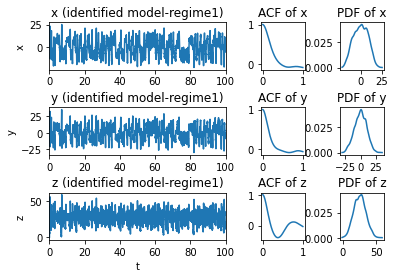

In [84]:
# independent run regime1 model
x1 = np.zeros(N)
y1 = np.zeros(N)
z1 = np.zeros(N)
der_x = np.zeros(N)
der_y = np.zeros(N)
der_z = np.zeros(N)
sol = np.squeeze(np.load('nature_run1.npy'))
der = np.squeeze(np.load('derivative.npy'))
x1[0] = sol[0,0]
y1[0] = sol[1,0]
z1[0] = sol[2,0]

np.random.seed(10)

for i in range(1, N):
    der_x[i-1] = (Theta1_Constraint[0] * x1[i - 1] + Theta1_Constraint[1] * y1[i - 1]) * dt + np.sqrt(Sigma1[0, 0] / dt) * np.sqrt(dt) * np.random.randn()
    der_y[i-1] = (Theta1_Constraint[2] * x1[i - 1] + Theta1_Constraint[3] * x1[i - 1]*z1[i - 1]) * dt + np.sqrt(Sigma1[1, 1] / dt) * np.sqrt(dt) * np.random.randn()
    der_z[i-1] = (Theta1_Constraint[4] * z1[i - 1] + Theta1_Constraint[5] * x1[i - 1]*y1[i - 1]) * dt + np.sqrt(Sigma1[2, 2] / dt) * np.sqrt(dt) * np.random.randn()
    x1[i] = x1[i - 1] + der_x[i-1]
    y1[i] = y1[i - 1] + der_y[i-1]
    z1[i] = z1[i - 1] + der_z[i-1]
    
# plot
fig = plt.figure()
widths = [8, 2, 2]
heights = [2, 2, 2]
spec = fig.add_gridspec(ncols=3, nrows=3, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.4, hspace=0.8)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[2, 0])
ax4 = fig.add_subplot(spec[0, 1])
ax5 = fig.add_subplot(spec[1, 1])
ax6 = fig.add_subplot(spec[2, 1])
ax7 = fig.add_subplot(spec[0, 2])
ax8 = fig.add_subplot(spec[1, 2])
ax9 = fig.add_subplot(spec[2, 2])

# Subplot for x_1
sel0 = 0
sel1 = N
ax1.plot(np.arange(0, N * dt, dt), x1)
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_title('x (identified model-regime1)')
ax1.set_ylabel('x')

ax2.plot(np.arange(0, N * dt, dt), y1)
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_title('y (identified model-regime1)')
ax2.set_ylabel('y')

ax3.plot(np.arange(0, N * dt, dt), z1)
ax3.set_xlim(sel0*dt, sel1*dt)
ax3.set_title('z (identified model-regime1)')
ax3.set_ylabel('z')
ax3.set_xlabel('t')

# Subplot for ACF of x_1
ax4.plot(np.arange(0, Lag * dt, dt), stattools.acf(x1, nlags=Lag-1))
ax4.set_title('ACF of x')

ax5.plot(np.arange(0, Lag * dt, dt), stattools.acf(y1, nlags=Lag-1))
ax5.set_title('ACF of y')

ax6.plot(np.arange(0, Lag * dt, dt), stattools.acf(z1, nlags=Lag-1))
ax6.set_title('ACF of z')

# Subplot for PDF of x_1
kde = gaussian_kde(x1)
xx = np.linspace(np.min(x1), np.max(x1), 100)
fi = kde.evaluate(xx)
ax7.plot(xx, fi)
ax7.set_title('PDF of x')

kde = gaussian_kde(y1)
xx = np.linspace(np.min(y1), np.max(y1), 100)
fi = kde.evaluate(xx)
ax8.plot(xx, fi)
ax8.set_title('PDF of y')

kde = gaussian_kde(z1)
xx = np.linspace(np.min(z1), np.max(z1), 100)
fi = kde.evaluate(xx)
ax9.plot(xx, fi)
ax9.set_title('PDF of z')
plt.savefig('../../fig/Regime1CEM_Phy.png', dpi=150)
plt.show()

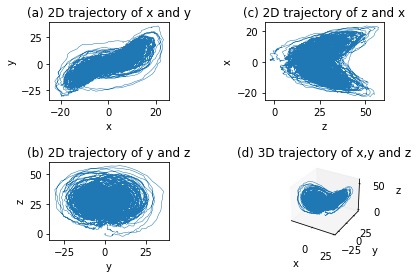

In [86]:
# plot
fig = plt.figure()
widths = [3, 3]
heights = [16, 16]
spec = fig.add_gridspec(ncols=2, nrows=2, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.8, hspace=0.8)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[0, 1])
ax4 = fig.add_subplot(spec[1, 1], projection='3d')

# Subplot for x_1
ax1.plot(x1, y1, lw=0.5)
ax1.set_title('(a) 2D trajectory of x and y')
ax1.set_xlabel('x')
ax1.set_ylabel('y')

ax2.plot(y1, z1, lw=0.5)
ax2.set_title('(b) 2D trajectory of y and z')
ax2.set_xlabel('y')
ax2.set_ylabel('z')

ax3.plot(z1, x1, lw=0.5)
ax3.set_title('(c) 2D trajectory of z and x')
ax3.set_xlabel('z')
ax3.set_ylabel('x')

ax4.plot(x1, y1, z1, lw=0.5)
ax4.set_xlabel("x")
ax4.set_ylabel("y")
ax4.set_zlabel("z")
ax4.set_title('(d) 3D trajectory of x,y and z')
ax4.grid(False)
    
plt.savefig('../../fig/Regime1CEMPhy_2dtraj.png', dpi=150)
plt.show()

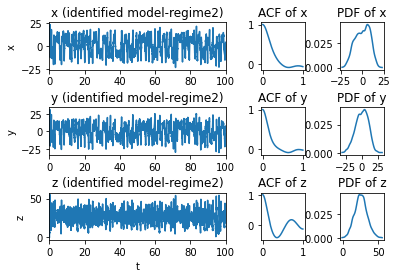

In [87]:
# independent run regime2 model
x1 = np.zeros(N)
y1 = np.zeros(N)
z1 = np.zeros(N)
der_x = np.zeros(N)
der_y = np.zeros(N)
der_z = np.zeros(N)
sol = np.squeeze(np.load('nature_run1.npy'))
der = np.squeeze(np.load('derivative.npy'))
x1[0] = sol[0,0]
y1[0] = sol[1,0]
z1[0] = sol[2,0]

np.random.seed(10)

for i in range(1, N):
    der_x[i-1] = (Theta2_Constraint[0] * x1[i - 1] + Theta2_Constraint[1] * y1[i - 1]) * dt + np.sqrt(Sigma1[0, 0] / dt) * np.sqrt(dt) * np.random.randn()
    der_y[i-1] = (Theta2_Constraint[2] * x1[i - 1] + Theta2_Constraint[3] * x1[i - 1]*z1[i - 1]) * dt + np.sqrt(Sigma1[1, 1] / dt) * np.sqrt(dt) * np.random.randn()
    der_z[i-1] = (Theta2_Constraint[4] * z1[i - 1] + Theta2_Constraint[5] * x1[i - 1]*y1[i - 1]) * dt + np.sqrt(Sigma1[2, 2] / dt) * np.sqrt(dt) * np.random.randn()
    x1[i] = x1[i - 1] + der_x[i-1]
    y1[i] = y1[i - 1] + der_y[i-1]
    z1[i] = z1[i - 1] + der_z[i-1]
    
# plot
fig = plt.figure()
widths = [8, 2, 2]
heights = [2, 2, 2]
spec = fig.add_gridspec(ncols=3, nrows=3, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.4, hspace=0.8)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[2, 0])
ax4 = fig.add_subplot(spec[0, 1])
ax5 = fig.add_subplot(spec[1, 1])
ax6 = fig.add_subplot(spec[2, 1])
ax7 = fig.add_subplot(spec[0, 2])
ax8 = fig.add_subplot(spec[1, 2])
ax9 = fig.add_subplot(spec[2, 2])

# Subplot for x_1
sel0 = 0
sel1 = N
ax1.plot(np.arange(0, N * dt, dt), x1)
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_title('x (identified model-regime2)')
ax1.set_ylabel('x')

ax2.plot(np.arange(0, N * dt, dt), y1)
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_title('y (identified model-regime2)')
ax2.set_ylabel('y')

ax3.plot(np.arange(0, N * dt, dt), z1)
ax3.set_xlim(sel0*dt, sel1*dt)
ax3.set_title('z (identified model-regime2)')
ax3.set_ylabel('z')
ax3.set_xlabel('t')

# Subplot for ACF of x_1
ax4.plot(np.arange(0, Lag * dt, dt), stattools.acf(x1, nlags=Lag-1))
ax4.set_title('ACF of x')

ax5.plot(np.arange(0, Lag * dt, dt), stattools.acf(y1, nlags=Lag-1))
ax5.set_title('ACF of y')

ax6.plot(np.arange(0, Lag * dt, dt), stattools.acf(z1, nlags=Lag-1))
ax6.set_title('ACF of z')

# Subplot for PDF of x_1
kde = gaussian_kde(x1)
xx = np.linspace(np.min(x1), np.max(x1), 100)
fi = kde.evaluate(xx)
ax7.plot(xx, fi)
ax7.set_title('PDF of x')

kde = gaussian_kde(y1)
xx = np.linspace(np.min(y1), np.max(y1), 100)
fi = kde.evaluate(xx)
ax8.plot(xx, fi)
ax8.set_title('PDF of y')

kde = gaussian_kde(z1)
xx = np.linspace(np.min(z1), np.max(z1), 100)
fi = kde.evaluate(xx)
ax9.plot(xx, fi)
ax9.set_title('PDF of z')
plt.savefig('../../fig/Regime2CEM_Phy.png', dpi=150)
plt.show()

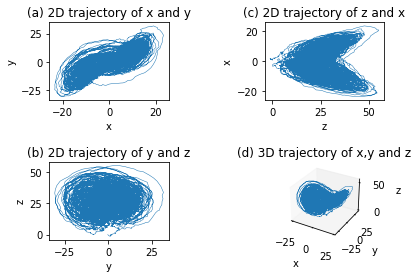

In [88]:
# plot
fig = plt.figure()
widths = [3, 3]
heights = [16, 16]
spec = fig.add_gridspec(ncols=2, nrows=2, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.8, hspace=0.8)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[0, 1])
ax4 = fig.add_subplot(spec[1, 1], projection='3d')

# Subplot for x_1
ax1.plot(x1, y1, lw=0.5)
ax1.set_title('(a) 2D trajectory of x and y')
ax1.set_xlabel('x')
ax1.set_ylabel('y')

ax2.plot(y1, z1, lw=0.5)
ax2.set_title('(b) 2D trajectory of y and z')
ax2.set_xlabel('y')
ax2.set_ylabel('z')

ax3.plot(z1, x1, lw=0.5)
ax3.set_title('(c) 2D trajectory of z and x')
ax3.set_xlabel('z')
ax3.set_ylabel('x')

ax4.plot(x1, y1, z1, lw=0.5)
ax4.set_xlabel("x")
ax4.set_ylabel("y")
ax4.set_zlabel("z")
ax4.set_title('(d) 3D trajectory of x,y and z')
ax4.grid(False)
    
plt.savefig('../../fig/Regime2CEMPhy_2dtraj.png', dpi=150)
plt.show()

In [4]:
# Surrogate model with Model Identification - simpler model
from scipy.linalg import det

True_Model_Structure = np.array([[1, 1, 0, 0, 0, 0],
                                 [1, 1, 0, 0, 1, 0],
                                 [0, 0, 1, 1, 0, 0]], dtype=int)

# Parameters
threshold = 0.0001 # threshold of causation entropy
L = 6

# load label data
label = np.load('SeqKmeans_label_2center_naturerun.npy')
print(label.shape)

lagtime  = 32
# Truth
x_truth = truth[0, 0, lagtime:]
y_truth = truth[1, 0, lagtime:]
z_truth = truth[2, 0, lagtime:]

# Define candidates and true model structure
All_Candidates = np.vstack((x_truth, y_truth, z_truth, x_truth * y_truth, z_truth * x_truth, x_truth**2))

# Partition data into 8 regimes
ncenters = 2
x_truths = []
y_truths = []
z_truths = []
All_Candi_list = []
indts = []
iind_cuts = []

for nc in range(ncenters):
    bool_label = label == nc
    x_truths.append(x_truth[bool_label])
    y_truths.append(y_truth[bool_label])
    z_truths.append(z_truth[bool_label])
    All_Candi_list.append(All_Candidates[:,bool_label][:, :-1])   # Remove last point from candidates
    indts.append(np.where(bool_label)[0][:-1]) 

    indt = indts[nc]
    ind_cut = [indt[0]]
    for i in range(indt.shape[0]-1):
        if (indt[i+1] - indt[i]) > 1:
            ind_cut.append(indt[i+1])
            
    # Use numpy.in1d to create a boolean mask for elements in arr that are in elements_to_find
    mask = np.in1d(indt, ind_cut)
    # Use numpy.where to get the indices where the mask is True
    iind_cut = np.where(mask)[0]
    iind_cut = np.append(iind_cut, indt.shape[0])
    iind_cuts.append(iind_cut)

# Compute time derivatives
deriv = np.load('derivative.npy')
deriv = np.roll(deriv[:,0,lagtime:], -1, axis=1) # shift derivatives by -1, since deriv[i] corresponds to sol[i+1]
deriv1 = deriv[:,bool_label]
deriv2 = deriv[:,~bool_label][:, :-1] # remove the last element
x_derivative1 = deriv1[0,:] / dt
y_derivative1 = deriv1[1,:] / dt
z_derivative1 = deriv1[2,:] / dt
x_derivative2 = deriv2[0,:] / dt
y_derivative2 = deriv2[1,:] / dt
z_derivative2 = deriv2[2,:] / dt

print(deriv2.shape, All_Candidates2.shape)
print('Candidate functions:')
print('x, y, z, xy, zx, x^2')

# regime1
# Calculate causation entropy matrix (CEM) based on the Gaussian approximation
CEM = np.zeros((3, L))
for k in range(3):
    if k == 0:
        All_Variables1 = np.vstack((All_Candidates1, x_derivative1))
    elif k == 1:
        All_Variables1 = np.vstack((All_Candidates1, y_derivative1))
    elif k == 2:
        All_Variables1 = np.vstack((All_Candidates1, z_derivative1))
    
    All_Cov = np.cov(All_Variables1)
    
    for i in range(L):
        RXY = np.delete(np.delete(All_Cov, i, axis=0), i, axis=1)
        RY = np.delete(np.delete(All_Cov, [i, L], axis=0), [i, L], axis=1)
        RXYZ = All_Cov
        RYZ = All_Cov[:L, :L]

        CEM[k, i] = 0.5 * (np.log(det(RXY)) - np.log(det(RY)) - np.log(det(RXYZ)) + np.log(det(RYZ)))
        
CEM_Original1 = CEM
CEM_indicator1 = (CEM_Original1 > threshold).astype(int)

print('Regime1')
print('Model structure (truth):')
print(True_Model_Structure)
print('Model structure (identified model):')
print(CEM_indicator1)
print('CEM_Original',CEM_Original1)

# regime2
# Calculate causation entropy matrix (CEM) based on the Gaussian approximation
CEM = np.zeros((3, L))
for k in range(3):
    if k == 0:
        All_Variables2 = np.vstack((All_Candidates2, x_derivative2))
    elif k == 1:
        All_Variables2 = np.vstack((All_Candidates2, y_derivative2))
    elif k == 2:
        All_Variables2 = np.vstack((All_Candidates2, z_derivative2))
    
    All_Cov = np.cov(All_Variables2)
    
    for i in range(L):
        RXY = np.delete(np.delete(All_Cov, i, axis=0), i, axis=1)
        RY = np.delete(np.delete(All_Cov, [i, L], axis=0), [i, L], axis=1)
        RXYZ = All_Cov
        RYZ = All_Cov[:L, :L]

        CEM[k, i] = 0.5 * (np.log(det(RXY)) - np.log(det(RY)) - np.log(det(RXYZ)) + np.log(det(RYZ)))
        
CEM_Original2 = CEM
CEM_indicator2 = (CEM_Original2 > threshold).astype(int)

print('Regime2')
print('Model structure (truth):')
print(True_Model_Structure)
print('Model structure (identified model):')
print(CEM_indicator2)
print('CEM_Original',CEM_Original2)

(19969,)


NameError: name 'All_Candidates2' is not defined

# Reproduce of example code

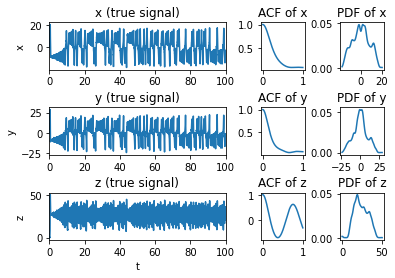

In [24]:
# reproduce
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import gaussian_kde
from statsmodels.tsa import stattools 

# Fix the random number seed to reproduce results
np.random.seed(10)

# Define parameters
T = 100
dt = 0.001
N = int(round(T / dt))
sigma = 10
rho = 28
beta = 8/3
sigma_x = 1
sigma_y = 1
sigma_z = 1
Lag = 1000

# Generating true model series
# Initialize state variables and truth arrays
x_truth = np.zeros(N)
y_truth = np.zeros(N)
z_truth = np.zeros(N)
x_truth[0] = 0
y_truth[0] = 0
z_truth[0] = 0

# Generate the true time series using numerical integration
for i in range(1, N):
    x_truth[i] = x_truth[i-1] + sigma * (y_truth[i-1] - x_truth[i-1]) * dt + sigma_x * np.sqrt(dt) * np.random.randn()
    y_truth[i] = y_truth[i-1] + (x_truth[i-1] * (rho - z_truth[i-1]) - y_truth[i-1]) * dt + sigma_y * np.sqrt(dt) * np.random.randn()
    z_truth[i] = z_truth[i-1] + (x_truth[i-1] * y_truth[i-1] - beta * z_truth[i-1]) * dt + sigma_z * np.sqrt(dt) * np.random.randn()

fig = plt.figure()
widths = [8, 2, 2]
heights = [2, 2, 2]
spec = fig.add_gridspec(ncols=3, nrows=3, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.4, hspace=0.8)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[2, 0])
ax4 = fig.add_subplot(spec[0, 1])
ax5 = fig.add_subplot(spec[1, 1])
ax6 = fig.add_subplot(spec[2, 1])
ax7 = fig.add_subplot(spec[0, 2])
ax8 = fig.add_subplot(spec[1, 2])
ax9 = fig.add_subplot(spec[2, 2])

# Subplot for x_truth
sel0 = 0
sel1 = N
ax1.plot(np.arange(0, N * dt, dt), x_truth)
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_title('x (true signal)')
ax1.set_ylabel('x')

ax2.plot(np.arange(0, N * dt, dt), y_truth)
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_title('y (true signal)')
ax2.set_ylabel('y')

ax3.plot(np.arange(0, N * dt, dt), z_truth)
ax3.set_xlim(sel0*dt, sel1*dt)
ax3.set_title('z (true signal)')
ax3.set_ylabel('z')
ax3.set_xlabel('t')

# Subplot for ACF of x_truth
ax4.plot(np.arange(0, Lag * dt, dt), stattools.acf(x_truth, nlags=Lag-1))
ax4.set_title('ACF of x')

ax5.plot(np.arange(0, Lag * dt, dt), stattools.acf(y_truth, nlags=Lag-1))
ax5.set_title('ACF of y')

ax6.plot(np.arange(0, Lag * dt, dt), stattools.acf(z_truth, nlags=Lag-1))
ax6.set_title('ACF of z')

# Subplot for PDF of x_truth
kde = gaussian_kde(x_truth)
xx = np.linspace(np.min(x_truth), np.max(x_truth), 100)
fi = kde.evaluate(xx)
ax7.plot(xx, fi)
ax7.set_title('PDF of x')

kde = gaussian_kde(y_truth)
xx = np.linspace(np.min(y_truth), np.max(y_truth), 100)
fi = kde.evaluate(xx)
ax8.plot(xx, fi)
ax8.set_title('PDF of y')

kde = gaussian_kde(z_truth)
xx = np.linspace(np.min(z_truth), np.max(z_truth), 100)
fi = kde.evaluate(xx)
ax9.plot(xx, fi)
ax9.set_title('PDF of z')
# plt.savefig('../../fig/truesign.png', dpi=150)')
plt.show()

In [35]:
# Model Identification
from scipy.linalg import det

# Parameters
threshold = 0.0003 # threshold of causation entropy
L = 9

# Define candidates and true model structure
All_Candidates = np.vstack((x_truth, y_truth, z_truth, x_truth * y_truth, y_truth * z_truth, z_truth * x_truth, x_truth**2, y_truth**2, z_truth**2))
True_Model_Structure = np.array([[1, 1, 0, 0, 0, 0, 0, 0, 0],
                                 [1, 1, 0, 0, 0, 1, 0, 0, 0],
                                 [0, 0, 1, 1, 0, 0, 0, 0, 0]], dtype=int)

# Remove last point from candidates
All_Candidates = All_Candidates[:, :-1]

# Compute time derivatives
x_derivative = np.diff(x_truth) / dt
y_derivative = np.diff(y_truth) / dt
z_derivative = np.diff(z_truth) / dt

# Calculate causation entropy matrix (CEM) based on the Gaussian approximation
CEM = np.zeros((3, L))
for k in range(3):
    if k == 0:
        All_Variables = np.vstack((All_Candidates, x_derivative))
    elif k == 1:
        All_Variables = np.vstack((All_Candidates, y_derivative))
    elif k == 2:
        All_Variables = np.vstack((All_Candidates, z_derivative))
    
    All_Cov = np.cov(All_Variables)
    
    for i in range(L):
        RXY = np.delete(np.delete(All_Cov, i, axis=0), i, axis=1)
        RY = np.delete(np.delete(All_Cov, [i, L], axis=0), [i, L], axis=1)
        RXYZ = All_Cov
        RYZ = All_Cov[:L, :L]

        CEM[k, i] = 0.5 * (np.log(det(RXY)) - np.log(det(RY)) - np.log(det(RXYZ)) + np.log(det(RYZ)))
        
CEM_Original = CEM
CEM_indicator = (CEM_Original > threshold).astype(int)

print('Candidate functions:')
print('x, y, z, xy, yz, zx, x^2, y^2, z^2')
print('Model structure (truth):')
print(True_Model_Structure)
print('Model structure (identified model):')
print(CEM_indicator)

Candidate functions:
x, y, z, xy, yz, zx, x^2, y^2, z^2
Model structure (truth):
[[1 1 0 0 0 0 0 0 0]
 [1 1 0 0 0 1 0 0 0]
 [0 0 1 1 0 0 0 0 0]]
Model structure (identified model):
[[1 1 0 0 0 0 0 0 0]
 [1 1 0 0 0 1 0 0 0]
 [0 0 1 1 0 0 0 0 0]]


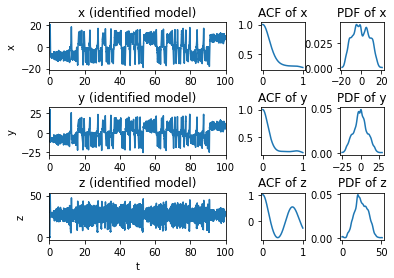

In [50]:
# Parameter estimation of the surrogate model
H = np.zeros(7)
H[[4, 6]] = 1
H = H[None, :]
g = 0
Theta = np.zeros(7)
Sigma = np.zeros((3, 3))

for _ in range(10):
    for i in range(N - 1):
        M = np.zeros((3, 7))
        M[0, 0] = All_Candidates[0, i]
        M[0, 1] = All_Candidates[1, i]
        M[1, 2] = All_Candidates[0, i]
        M[1, 3] = All_Candidates[1, i]
        M[1, 4] = All_Candidates[5, i]
        M[2, 5] = All_Candidates[2, i]
        M[2, 6] = All_Candidates[3, i]
        M = M * dt
        z = np.array([x_truth[i + 1], y_truth[i + 1], z_truth[i + 1]])
        s = np.array([x_truth[i], y_truth[i], z_truth[i]])
        Sigma += np.outer(z - M @ Theta - s, z - M @ Theta - s)

    Sigma = Sigma / (N - 1) * np.eye(3)
    invSigma = np.linalg.inv(Sigma)
    D = np.zeros((7, 7))
    c = np.zeros(7)
    
    for i in range(N - 1):
        M = np.zeros((3, 7))
        M[0, 0] = All_Candidates[0, i]
        M[0, 1] = All_Candidates[1, i]
        M[1, 2] = All_Candidates[0, i]
        M[1, 3] = All_Candidates[1, i]
        M[1, 4] = All_Candidates[5, i]
        M[2, 5] = All_Candidates[2, i]
        M[2, 6] = All_Candidates[3, i]
        M = M * dt
        z = np.array([x_truth[i + 1], y_truth[i + 1], z_truth[i + 1]])
        s = np.array([x_truth[i], y_truth[i], z_truth[i]])
        D += M.T @ invSigma @ M
        c += M.T @ invSigma @ (z - s)

    D = D / (N - 1)
    c = c / (N - 1)
    Theta1 = np.linalg.solve(D, c)
    lambda_val = np.linalg.inv(H @ np.linalg.inv(D) @ H.T) @ (H @ np.linalg.inv(D) @ c - g)
    Theta1_Constraint = np.linalg.solve(D, c - H.T @ lambda_val)

Sigma1 = Sigma

print('Theta1_Constraint\n',Theta1_Constraint)
print('Sigma1\n',Sigma1)

x1 = np.zeros(N)
y1 = np.zeros(N)
z1 = np.zeros(N)
x1[0] = 0
y1[0] = 0
z1[0] = 0

np.random.seed(10)
for i in range(1, N):
    x1[i] = x1[i - 1] + (Theta1_Constraint[0] * x1[i - 1] + Theta1_Constraint[1] * y1[i - 1]) * dt + np.sqrt(Sigma1[0, 0] / dt) * np.sqrt(dt) * np.random.randn()
    y1[i] = y1[i - 1] + (Theta1_Constraint[2] * x1[i - 1] + Theta1_Constraint[3] * y1[i - 1] + Theta1_Constraint[4] * z1[i - 1] * x1[i - 1]) * dt + np.sqrt(Sigma1[1, 1] / dt) * np.sqrt(dt) * np.random.randn()
    z1[i] = z1[i - 1] + (Theta1_Constraint[5] * z1[i - 1] + Theta1_Constraint[6] * x1[i - 1] * y1[i - 1]) * dt + np.sqrt(Sigma1[2, 2] / dt) * np.sqrt(dt) * np.random.randn()

# plot
fig = plt.figure()
widths = [8, 2, 2]
heights = [2, 2, 2]
spec = fig.add_gridspec(ncols=3, nrows=3, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.4, hspace=0.8)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[2, 0])
ax4 = fig.add_subplot(spec[0, 1])
ax5 = fig.add_subplot(spec[1, 1])
ax6 = fig.add_subplot(spec[2, 1])
ax7 = fig.add_subplot(spec[0, 2])
ax8 = fig.add_subplot(spec[1, 2])
ax9 = fig.add_subplot(spec[2, 2])

# Subplot for x_1
sel0 = 0
sel1 = N
ax1.plot(np.arange(0, N * dt, dt), x1)
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_title('x (identified model)')
ax1.set_ylabel('x')

ax2.plot(np.arange(0, N * dt, dt), y1)
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_title('y (identified model)')
ax2.set_ylabel('y')

ax3.plot(np.arange(0, N * dt, dt), z1)
ax3.set_xlim(sel0*dt, sel1*dt)
ax3.set_title('z (identified model)')
ax3.set_ylabel('z')
ax3.set_xlabel('t')

# Subplot for ACF of x_1
ax4.plot(np.arange(0, Lag * dt, dt), stattools.acf(x1, nlags=Lag-1))
ax4.set_title('ACF of x')

ax5.plot(np.arange(0, Lag * dt, dt), stattools.acf(y1, nlags=Lag-1))
ax5.set_title('ACF of y')

ax6.plot(np.arange(0, Lag * dt, dt), stattools.acf(z1, nlags=Lag-1))
ax6.set_title('ACF of z')

# Subplot for PDF of x_1
kde = gaussian_kde(x1)
xx = np.linspace(np.min(x1), np.max(x1), 100)
fi = kde.evaluate(xx)
ax7.plot(xx, fi)
ax7.set_title('PDF of x')

kde = gaussian_kde(y1)
xx = np.linspace(np.min(y1), np.max(y1), 100)
fi = kde.evaluate(xx)
ax8.plot(xx, fi)
ax8.set_title('PDF of y')

kde = gaussian_kde(z1)
xx = np.linspace(np.min(z1), np.max(z1), 100)
fi = kde.evaluate(xx)
ax9.plot(xx, fi)
ax9.set_title('PDF of z')
# plt.savefig('../../fig/truesign.png', dpi=150)')
plt.show()


In [56]:
print('Theta1_Constraint\n',Theta1_Constraint)
print('Sigma1\n',Sigma1)

Theta1_Constraint
 [-10.01100199   9.9923489   27.99737131  -0.98615806  -1.00046792
  -2.67005843   1.00046792]
Sigma1
 [[0.00286208 0.         0.        ]
 [0.         0.00533873 0.        ]
 [0.         0.         0.00722632]]


In [29]:
truth.shape
x,y,z=truth[:,0,:15000]

In [30]:
x.shape

(15000,)

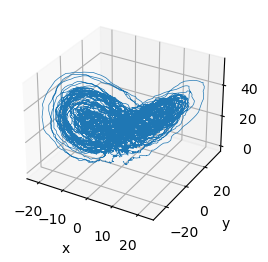

In [70]:
# Plotting
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111, projection='3d')
plt.subplots_adjust(left=0.05, right=0.8, top=1.0, bottom=0.05)
ax.plot(x, y, z, lw=0.5)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
# ax.set_title("the noisy Lorenz63")
plt.savefig('/Users/ree/Documents/UWMadison/courses/math703/final/noisyl63.png', dpi=150)
plt.show()

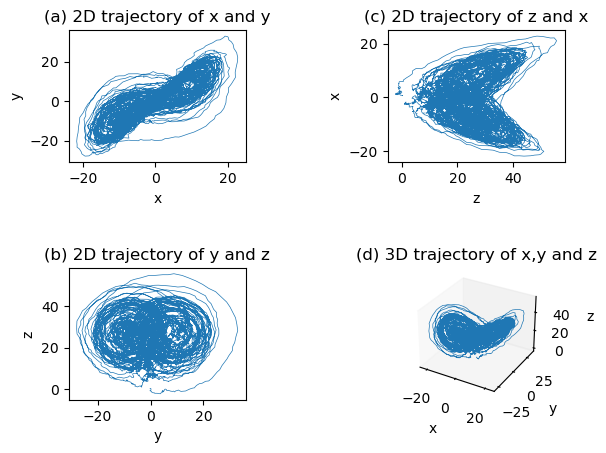

In [50]:
# plot
fig = plt.figure()
widths = [3, 3]
heights = [16, 16]
spec = fig.add_gridspec(ncols=2, nrows=2, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.8, hspace=0.8)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[0, 1])
ax4 = fig.add_subplot(spec[1, 1], projection='3d')

# Subplot for x_1
ax1.plot(x, y, lw=0.5)
ax1.set_title('(a) 2D trajectory of x and y')
ax1.set_xlabel('x')
ax1.set_ylabel('y')

ax2.plot(y, z, lw=0.5)
ax2.set_title('(b) 2D trajectory of y and z')
ax2.set_xlabel('y')
ax2.set_ylabel('z')

ax3.plot(z, x, lw=0.5)
ax3.set_title('(c) 2D trajectory of z and x')
ax3.set_xlabel('z')
ax3.set_ylabel('x')

ax4.plot(x, y, z, lw=0.5)
ax4.set_xlabel("x")
ax4.set_ylabel("y")
ax4.set_zlabel("z")
ax4.set_title('(d) 3D trajectory of x,y and z')
ax4.grid(False)
    
# plt.savefig('../../fig/Regime2CEMPhy_2dtraj.png', dpi=150)
plt.show()